## Описание проекта
**Для компании агрегатора услуг в сфере массовых развлечений   
провести аналитику с целью оптимизации маркетинговых затрат**

### Описание данных
Данные с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта;
- выгрузка всех заказов за этот период;
- статистика рекламных расходов.

### Задачи:
- определить сценарий использования продукта (сайта);
- определить когда клиенты начинают покупать;
- расчитать выручку с каждого клиента;
- определить срок окупаемости затрат на клиента.

In [1]:
# загружаем библиотеки для обработки данных

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt           # графики
import matplotlib.ticker as ticker
import seaborn as sns

## Содержание проекта

### [Проверка и предобработка данных предоставленных для анализа](#data)

- #### [Информация о посещении сайта](#visits)
    - #### [Устройства перехода](#device)
    - #### [Рекламные источники](#source)
    - #### [Уникальные пользователи](#uid)
    - #### [Проверка дубликатов](#dup_vis)
    
- #### [Информация о заказах](#orders)
    - #### [Уникальные пользователи](#orders_uid)
    - #### [Проверка дубликатов](#orders_dup)
    
- #### [Информация о затратах на маркетинг](#costs)
    - #### [Проверка дубликатов](#costs_dup)

- #### [Результаты осмотра и предобработки данных](#result_data_look)


### [Отчёты и метрики](#metrik)

- #### [Продукт](#product)
    - #### [Количество пользователей сервиса в день, неделю, месяц](#count)
        - #### [Графики количества пользователей по устройствам входа](#count_graf)
        - #### [Графики количества пользователей по рекламным источникам](#count_source_graf)
    - #### [Как часто пользователи возвращаются к сервису](#uid_return)
    - #### [Количество сессий в день на каждого пользователя](#count_sess)
    - #### [Длительность одной сессии](#dur_sess)
    
- #### [Продажи](#sales)
    - #### [Продолжительность сессии первой покупки](#sales_first)
    - #### [Количество покупок за период](#sales_count)
    - #### [Средний чек](#rev_per_uid)
        - #### [Средний чек по заказам на сайте](#rev_per_uid)
        - #### [Когортный анализ среднего чека по месяцам](#rev_per_uid_m)
        - #### [Активность пользователей в когортеъ](#rev_per_uid_m_activ)
    - #### [Выручка и доход с каждого пользователя (LTV)](#ltv)
        - #### [Расчет LTV по выручке](#ltv_marketing)
            - #### [График показателя LTV по выручке](#ltv_costs_graf)
        - #### [Стоимость привлечение одного покупателя из каждого источника](#costs_source_uid)
            
- #### [Итоги по блоку "Отчеты и метрики"](#result_sales)

- #### [Маркетинг](#marketing)
    - #### [Расчет затрат по рекламным источникам / по времени](#marketing)
    - #### [Общие затраты](#marketing)
    - #### [Затраты по рекламным источникам](#costs_source)
        - #### [Графики распределения затрат по рекламным источникам](#costs_source_graf)
        - #### [Вклад рекламных источников в объемы продаж](#costs_source_rev_graf)
    - #### [Насколько окупились расходы? (ROI)](#roi)
- #### [Итоги по блоку "Маркетинг"](#result_marketing)

### [Заключение](#end)

## Проверка и предобработка данных  предоставленных для анализа<a name="data"></a>

### Лог сервера с информацией о посещениях сайта (***visits***)<a name="visits"></a>:

In [2]:
visits_df = pd.read_csv('visits_log.csv')
visits_df.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


-	`Uid` — уникальный идентификатор пользователя
-	`Device` — категория устройства пользователя
-	`Start Ts` — дата и время начала сессии
-	`End Ts` — дата и время окончания сессии
-   `Source Id` — идентификатор рекламного источника, из которого пришел пользователь

In [3]:
visits_df.shape

(359400, 5)

In [4]:
visits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


В таблице 359400 записей, отсутствующих записей нет, требуется:
- перевести названия столбцов в нижний регистр;
- убрать пробелы из названий столбцов;
- перевести данные по датам в соответствующий формат
- проверить дубликаты.

In [5]:
visits_df.columns = visits_df.columns.str.lower() # приведем название столбцов к нижнему регистру
visits_df.columns

Index(['device', 'end ts', 'source id', 'start ts', 'uid'], dtype='object')

In [6]:
visits_df.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid'] # переименовали столбцы
visits_df.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [7]:
# переведем даты в соответствующий формат
visits_df.end_ts = pd.to_datetime(visits_df.end_ts)
visits_df.start_ts = pd.to_datetime(visits_df.start_ts)
visits_df.info()   #  проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


#### Используемые для перехода устройства<a name="device"></a>:

In [8]:
visits_df.device.unique()          # какие устройства фиксируются в системе.

array(['touch', 'desktop'], dtype=object)

Устройства которые фиксируются в системе разделяются на два вида:
- `настольные` - компьютеры всех видов
- `touch` - видимо мобильные устройства с сенсорными экранами (телефоны и планшеты)

In [9]:
visits_df.device.value_counts() # количество переходов с каждого устройства

desktop    262567
touch       96833
Name: device, dtype: int64

Количество переходов с настольных устройств в 2 раза больше (ну понятно 2017-2018 гг.)

#### Распределение данных по рекламным источникам<a name="source"></a>:

In [10]:
visits_df.source_id.describe()  #  сколько рекламных источников 

count    359400.000000
mean          3.750515
std           1.917116
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max          10.000000
Name: source_id, dtype: float64

**Распределение переходов c рекламных источников**

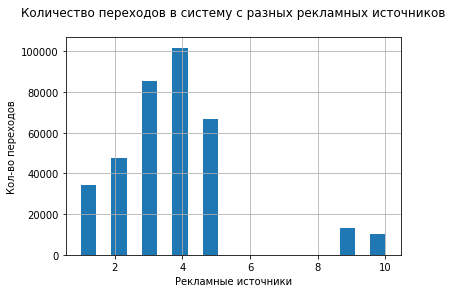

In [11]:
visits_df.source_id.hist(bins=20)
plt.title('Количество переходов в систему с разных рекламных источников\n ')
plt.ylabel('Кол-во переходов')
plt.xlabel('Рекламные источники');

**Количество переходов с рекламных источников**

In [12]:
visits_df.source_id.value_counts() 

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: source_id, dtype: int64

Рекламных источников 10, наибольший приток пользователей с 1 по 5 источник. Расшифровки источников нет.  
Переходов с рекламных источников 6, 7 практически нет, источник 8 не используется клиентами.    
С источников 9 и 10 единичные переходы.

#### Определим количество уникальных пользователей<a name="uid"></a>

In [13]:
visits_df.uid.value_counts().shape

(228169,)

Из 359400 записей, уникальных пользователей 228169 - порядка 60% от всей базы.

#### Проверим дубликаты<a name="dup_vis"></a>

In [14]:
visits_df.duplicated().sum()  # проверка дубликатов

0

Дубликатов в таблице нет.

### Информация о заказах (***orders***)<a name="orders"></a>

In [15]:
orders_df = pd.read_csv('orders_log.csv')
orders_df.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


- `Uid` — уникальный id пользователя, который сделал заказ
- `Buy Ts` — дата и время заказа
- `Revenue` — выручка компании с этого заказа

In [16]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


В базе 50415 записей, пропущенных данных нет, столбец с датами нужно перевести в соответствущий тип, заменить названия столбцов, проверить дубликаты.

In [17]:
orders_df.columns = orders_df.columns.str.lower()  # приведем название столбцов к нижнему регистру
orders_df.columns

Index(['buy ts', 'revenue', 'uid'], dtype='object')

In [18]:
orders_df.columns = ['buy_ts', 'revenue', 'uid']  # переименовали столбцы
orders_df.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

In [19]:
# переведем даты в соответствующий формат
orders_df.buy_ts = pd.to_datetime(orders_df.buy_ts)
orders_df.info()     #  проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


#### Определим количество уникальных пользователей<a name="orders_uid"></a>

In [20]:
orders_df.uid.value_counts().shape

(36523,)

Из 50415 записей, уникальных пользователей 36523

#### Проверим дубликаты<a name="orders_dup"></a>

In [21]:
orders_df.duplicated().sum()  # проверка дубликатов

0

Дубликатов нет.

### Информация о затратах на маркетинг (***costs***)<a name="costs"></a>

In [22]:
costs_df = pd.read_csv('costs.csv')
costs_df.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


- `source_id` — идентификатор рекламного источника
- `dt` — дата
- `costs` — затраты на этот рекламный источник в этот день

In [23]:
costs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


В базе 2542 записи, пропущенных данных нет, столбец с датами нужно перевести в соответствущий тип, проверить дубликаты.

In [24]:
# переведем даты в соответствующий формат
costs_df.dt = pd.to_datetime(costs_df.dt)
costs_df.info()     #  проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


#### Проверим дубликаты<a name="costs_dup"></a>

In [25]:
costs_df.duplicated().sum()  # проверка дубликатов

0

Дубликатов нет

### Результаты осмотра и предобработки данных<a name="result_data_look"></a>

**По всем данным проведены следующие операции:**
- названия столбцов переведены в нижний регистр;
- убраны пробелы из названий столбцов;
- данные по датам переведенв в соответствующий "временной" формат;
- данные проверены на наличие дубликатов - дубликатов нет.
    
**Приведенные данные показывают:**
- в системе фиксируются два устройства входа - "настольное" и "мобильное";
- количество переходов с настольных устройств более чем в 2 раза больше (262 тыс. vs 96 тыс.);
--------
- рекламных источников всего 10;
- наибольший приток пользователей с источников с 1 по 5;
- переходов с источников 6, 7 практически нет, источник 8 не используется клиентами, источников 9 и 10 единичные переходы;    
- разъяснений по названиям источников нет.  
--------
- уникальных пользователей 228 тыс. - порядка 60% от всей базы посещения сайта;
- оплатили заказ на сайте около 50 тыс. раз из них уникальных пользователей 36523.

In [26]:
converse = len(orders_df.uid.value_counts()) / len(visits_df.uid.value_counts())
'Конверсия с сайта получается равна {:.1%}'.format(converse) 

'Конверсия с сайта получается равна 16.0%'

>*Если считать что по оценкам экспертов для сайтов продающих билеты на концерты средняя конверсия 7,8% это хороший результат, то наш сервис лучший c 16%.*

# Отчёты и метрики<a name="metrik"></a>

## Продукт <a name="product"></a>
По этой части проекта требуется определить:
- Количество пользователей сервиса в день, неделю, месяц.
- Количество сессий в день.
- Длительность одной сессии.
- Частоту повторных обращений на сайт.

In [27]:
visits_df.head() # исходная таблица визитов

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


### Сколько людей пользуются сервисом в день, неделю, месяц?<a name="count"></a>

Расчитаем следующие метрики
**DAU** (daily active users) — количество уникальных пользователей в день;
**WAU** (weekly active users) — количество уникальных пользователей в неделю;
**MAU** (monthly active users) — количество уникальных пользователей в месяц.

Подготовим данные - выделим в отдельные столбцы год, месяц и неделю, а также полную дату начала сессии

In [28]:
visits_df['start_ts_year'] = visits_df['start_ts'].dt.year
visits_df['start_ts_month'] = visits_df['start_ts'].astype('datetime64[M]')
visits_df['start_ts_week'] = visits_df['start_ts'].astype('datetime64[W]')
visits_df['start_ts_data'] = visits_df['start_ts'].astype('datetime64[D]')

visits_df.head()

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_data
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,2018-02-15,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,2018-05-17,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,2017-12-21,2017-12-27


Посчитаем метрики **DAU**, **WAU**, **MAU**

In [29]:
dau_total = visits_df.groupby('start_ts_data').agg({'uid': 'nunique'}).mean()
wau_total = visits_df.groupby(['start_ts_year', 
                                'start_ts_week']).agg({'uid': 'nunique'}).mean()
mau_total = visits_df.groupby(['start_ts_year', 
                                'start_ts_month']).agg({'uid': 'nunique'}).mean()
print('Количество уникальных пользователей в день (DAU) = {}\n'
'Количество уникальных пользователей в неделю (WAU) = {}\n'
'Количество уникальных пользователей в месяц (MAU) = {}'.format(int(dau_total), int(wau_total), int(mau_total)))

Количество уникальных пользователей в день (DAU) = 907
Количество уникальных пользователей в неделю (WAU) = 5621
Количество уникальных пользователей в месяц (MAU) = 23228


### Графики количества пользователей сервиса по устройствам входа<a name="count_graf"></a>

**График распределения количества уникальных пользователей по устройствам входа и по дням    
за весь период июнь 2017 по конец мая 2018 года** 

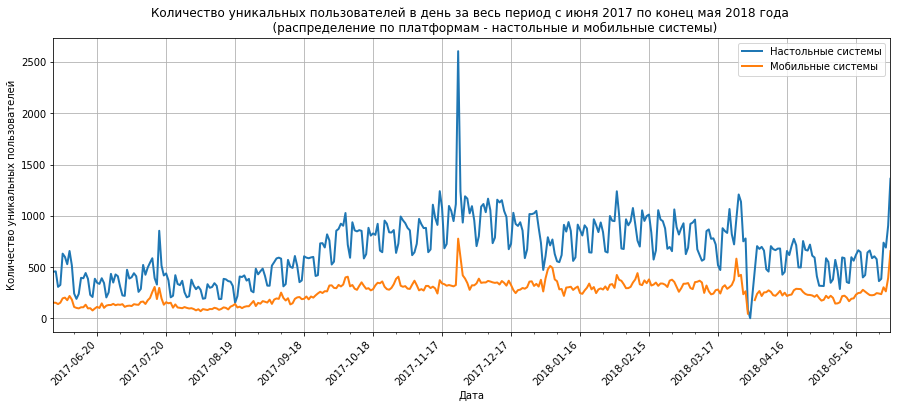

In [30]:
# таблица сгруппирована по количеству уникальных пользователей по дням 
# и по разным устройствам входа

ax = visits_df.pivot_table(index='start_ts_data', 
                           columns='device', 
                           aggfunc=({'uid': 'nunique'})).plot(figsize=(15, 6), lw=2)

plt.title('Количество уникальных пользователей в день за весь период с июня 2017 по конец мая 2018 года \n \
           (распределение по платформам - настольные и мобильные системы)')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Количество уникальных пользователей')
plt.grid(axis='both')
plt.legend(['Настольные системы', 'Мобильные системы'], loc='best')

#  устанавливаем интервал основных и вспомогательных делений:
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

**График распределения количества уникальных пользователей по устройствам входа и по неделям    
за весь период с июня 2017 по конец мая 2018 года**

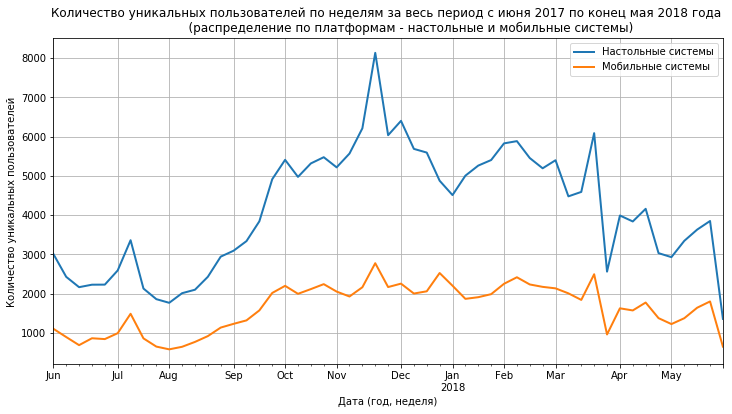

In [31]:
# таблица сгруппирована по количеству уникальных пользователей по неделям 
# и по разным устройствам входа

ax = visits_df.pivot_table(index='start_ts_week', 
                           columns='device', 
                           aggfunc=({'uid': 'nunique'})).plot(figsize=(12, 6), lw=2)

plt.title('Количество уникальных пользователей по неделям за весь период с июня 2017 по конец мая 2018 года \n \
           (распределение по платформам - настольные и мобильные системы)')
plt.xlabel('Дата (год, неделя)')
plt.ylabel('Количество уникальных пользователей')
plt.grid(axis='both')
plt.legend(['Настольные системы', 'Мобильные системы'], loc='best');

**График распределения количества уникальных пользователей по устройствам входа и по месяцам    
за весь период с июня 2017 по конец мая 2018 года**

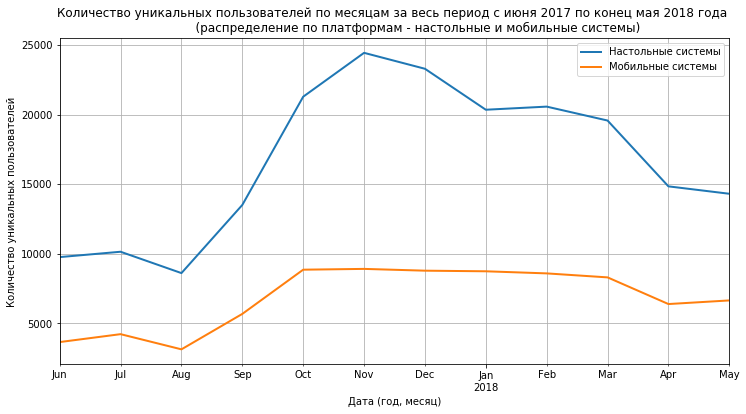

In [32]:
# таблица сгруппирована по количеству уникальных пользователей по месяцам 
# и по разным устройствам входа

ax = visits_df.pivot_table(index='start_ts_month', 
                           columns='device', 
                           aggfunc=({'uid': 'nunique'})).plot(figsize=(12, 6), lw=2)

plt.title('Количество уникальных пользователей по месяцам за весь период с июня 2017 по конец мая 2018 года \n \
           (распределение по платформам - настольные и мобильные системы)')
plt.xlabel('Дата (год, месяц)')
plt.ylabel('Количество уникальных пользователей')
plt.grid(which='both', axis='both')
plt.legend(['Настольные системы', 'Мобильные системы'], loc='best');

> Пользователей с настольных систем ожидаемо больше чем пользователей с мобильных устройств.
Количество пользователей растет с августа по декабрь 2017, и снижается далее до мая 2018 но не ниже уровня начала наблюдений.
Сервис постоянно прирастает новыми пользователями, несмотря на то что темпы прироста после Нового года снизились.

На графике по дням есть провал - выясним дату провала

In [33]:
# дата "провала" - там где наименьшее количество входов с разных устройств.
visits_df.pivot_table(index='start_ts_data', 
                           columns='device', 
                           aggfunc=({'uid': 'nunique'})).sort_values([('uid', 'desktop')]).head(2)

uid      
device        desktop touch
start_ts_data              
2018-03-31        1.0   NaN
2018-03-30       85.0  46.0

Подучается сервис не работал 31 марта 2018 г.?

### Графики количества пользователей сервиса по рекламным источникам<a name="count_source_graf"></a>

**График распределения количества уникальных пользователей по рекламным источникам и по дням    
за весь период июнь 2017 по конец мая 2018 года**

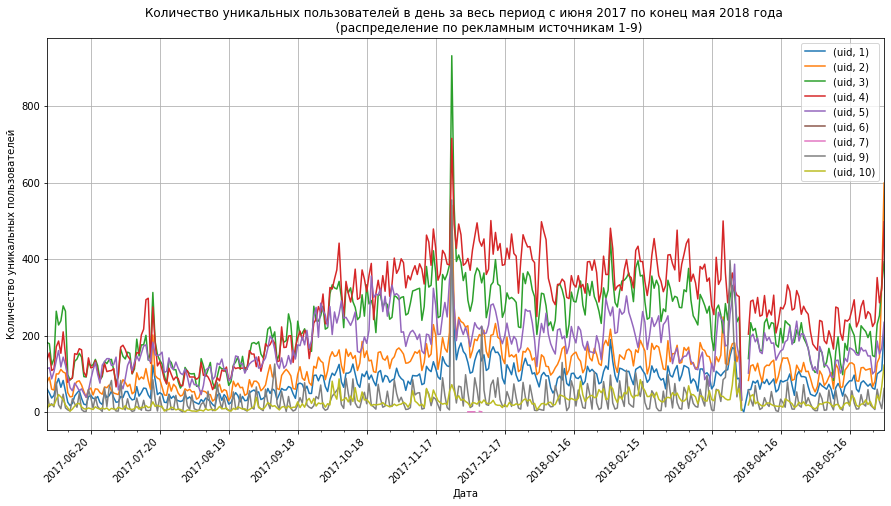

In [34]:
# таблица сгруппирована по количеству уникальных пользователей по дням 
# и по разным рекламным источникам

ax = visits_df.pivot_table(index='start_ts_data', 
                           columns='source_id', 
                           aggfunc=({'uid': 'nunique'})).plot(figsize=(15, 8))

plt.title('Количество уникальных пользователей в день за весь период с июня 2017 по конец мая 2018 года \n \
           (распределение по рекламным источникам 1-9)')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Количество уникальных пользователей')
plt.grid(axis='both')
plt.legend(loc='best')

#  устанавливаем интервал основных и вспомогательных делений:
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

**График распределения количества уникальных пользователей по рекламным источникам и по неделям    
за весь период с июня 2017 по конец мая 2018 года**

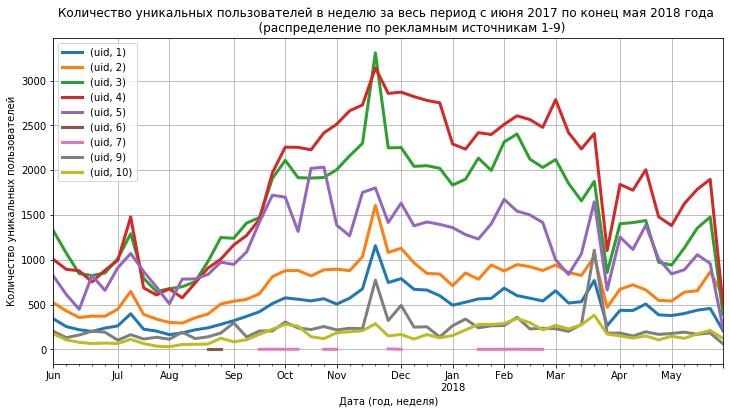

In [35]:
# таблица сгруппирована по количеству уникальных пользователей по неделям 
# и по разным рекламным источникам

ax = visits_df.pivot_table(index='start_ts_week', 
                           columns='source_id', 
                           aggfunc=({'uid': 'nunique'})).plot(figsize=(12, 6), lw=3)

plt.title('Количество уникальных пользователей в неделю за весь период с июня 2017 по конец мая 2018 года \n \
           (распределение по рекламным источникам 1-9)')
plt.xlabel('Дата (год, неделя)')
plt.ylabel('Количество уникальных пользователей')
plt.grid(axis='both')
plt.legend(loc='best');

**График распределения количества уникальных пользователей по рекламным источникам и по месяцам    
за весь период с июня 2017 по конец мая 2018 года**

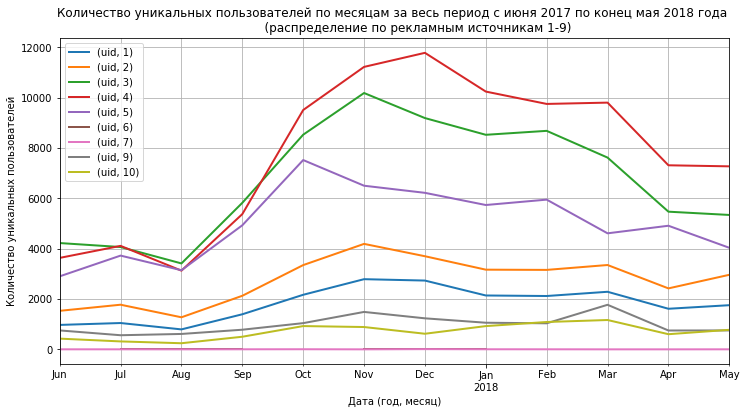

In [36]:
# таблица сгруппирована по количеству уникальных пользователей по месяцам 
# и по разным рекламным источникам

ax = visits_df.pivot_table(index='start_ts_month', columns='source_id', 
                           aggfunc=({'uid': 'nunique'})).plot(figsize=(12, 6), lw=2)

plt.title('Количество уникальных пользователей по месяцам за весь период с июня 2017 по конец мая 2018 года \n \
           (распределение по рекламным источникам 1-9)')
plt.xlabel('Дата (год, месяц)')
plt.ylabel('Количество уникальных пользователей')
plt.grid(which='both', axis='both')
plt.legend(loc='best');

> По график распределения сессий пользователей по рекламным источникам видно что лучше всего работают источники привлечения 3,4,5. Рост начинается в августе доходит пика в конце декабря и потом снижениие кол-ва сессий (картина повторяет) графики сессий по устройствам. Меньше всего переходов с источников 9 и 10. Источники 6 и 7 вообще не вносят никакой вклад в привлечение пользователей. (*график по дням конечно мало информативен*)

### Определим как часто пользователи возвращаются к сервису<a name="uid_return"></a>

Как часто пользователи пользуются сервисом можно определить по соотношению количества уникальных пользователей в разные периоды времени. Это покажет нам регулярность использования севисом **sticky factor**.    
Мы расчитали 
- Количество уникальных пользователей в день - **DAU = 907**
- Количество уникальных пользователей в неделю - **WAU = 5716**
- Количество уникальных пользователей в месяц - **MAU = 23228**

**sticky factor** может рассчитваться как понедельно так и по месячно и показывает лояльность пользователей к сервису

In [37]:
sticky_wau = dau_total.uid / wau_total.uid 
sticky_mau = dau_total.uid / mau_total.uid

print('Лояльность аудитории понедельная = {:.2%}\n'
'Лояльность аудитории помесячная = {:.2%}'.format(sticky_wau, sticky_mau))

Лояльность аудитории понедельная = 16.15%
Лояльность аудитории помесячная = 3.91%


Получается, что повторно к сервису обращается 16 человек из 100 в неделю и всего 4 из 100 каждый месяц.

**Retention Rate** показывает, сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды - определяет **Количество лояльных пользователей**   

**Retention Rate** - отношение количества активных пользователей в n-период времени к исходному количеству активных пользователей.

In [38]:
visits_df.head() # таблица данных

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_data
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,2018-02-15,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,2018-05-17,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,2017-12-21,2017-12-27


In [39]:
# находим дату первого посещения
first_activ_data = visits_df.groupby(['uid'])['start_ts_data'].min()
first_activ_data.name = 'first_activ_data'

visits_df = visits_df.join(first_activ_data, on='uid') # объединяем с основным датафреймом
visits_df.sample()

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_data,first_activ_data
171788,touch,2017-10-26 19:55:00,5,2017-10-26 19:52:00,3937730552328368652,2017,2017-10-01,2017-10-26,2017-10-26,2017-10-26


In [40]:
# обозначим также неделю и месяц первой сессии
visits_df['first_activ_month'] = visits_df['first_activ_data'].astype('datetime64[M]')
visits_df['first_activ_week'] = visits_df['first_activ_data'].astype('datetime64[W]')
visits_df.sample()

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_data,first_activ_data,first_activ_month,first_activ_week
220481,desktop,2017-10-02 10:16:00,4,2017-10-02 10:14:00,15129927368819830290,2017,2017-10-01,2017-09-28,2017-10-02,2017-10-02,2017-10-01,2017-09-28


In [41]:
# расчитаем время жизни когорты
visits_df['cohort_lifetime'] = visits_df['start_ts'] - visits_df['first_activ_month']
visits_df['cohort_lifetime'] = visits_df['cohort_lifetime'] / np.timedelta64(1,'M')
visits_df['cohort_lifetime'] = visits_df['cohort_lifetime'].astype('int')
visits_df.sample()

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_data,first_activ_data,first_activ_month,first_activ_week,cohort_lifetime
219624,desktop,2017-11-16 10:04:00,1,2017-11-16 09:43:00,15443668709274349741,2017,2017-11-01,2017-11-16,2017-11-16,2017-11-15,2017-11-01,2017-11-09,0


In [42]:
# данные по когортам
cohorts_ret = visits_df.groupby(['first_activ_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts_ret.head()

,first_activ_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1030
2,2017-06-01,2,687
3,2017-06-01,3,834
4,2017-06-01,4,899


Исходное количество пользователей в когорте возьмём из "нулевой" недели

In [43]:
init_users_count = cohorts_ret[cohorts_ret['cohort_lifetime'] == 0][['first_activ_month','uid']]
init_users_count = init_users_count.rename(columns={'uid':'cohort_uid'})
init_users_count.head()

,first_activ_month,cohort_uid
0,2017-06-01,13259
12,2017-07-01,12856
24,2017-08-01,9749
34,2017-09-01,16704
43,2017-10-01,25256


In [44]:
# объединяем с информацией о когортах
cohorts_ret = cohorts_ret.merge(init_users_count, on='first_activ_month')
cohorts_ret.head()

,first_activ_month,cohort_lifetime,uid,cohort_uid
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1030,13259
2,2017-06-01,2,687,13259
3,2017-06-01,3,834,13259
4,2017-06-01,4,899,13259


In [45]:
# расчитываем Retention Rate
cohorts_ret['retention'] = cohorts_ret['uid'] / cohorts_ret['cohort_uid']
cohorts_ret.head()

,first_activ_month,cohort_lifetime,uid,cohort_uid,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1030,13259,0.077683
2,2017-06-01,2,687,13259,0.051814
3,2017-06-01,3,834,13259,0.062901
4,2017-06-01,4,899,13259,0.067803


In [46]:
cohorts_ret.shape

(82, 5)

In [47]:
# объединяем данные в сводную таблицу
retention = cohorts_ret.pivot_table(index='first_activ_month', columns='cohort_lifetime', 
                                values='retention', aggfunc='sum')
retention.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activ_month,,,,,,,,,,,,
2017-06-01,1.0,0.077683,0.0518139,0.0629007,0.067803,0.0724037,0.0617694,0.0558866,0.0555849,0.0497775,0.041255,0.0443472
2017-07-01,1.0,0.077551,0.0534381,0.0563939,0.0607498,0.04986,0.0453485,0.0502489,0.0392813,0.0293248,0.0277691,0.000544493
2017-08-01,1.0,0.121859,0.063186,0.0668787,0.0522105,0.0451328,0.0411324,0.0394912,0.0296441,0.0265668,,
2017-09-01,1.0,0.084471,0.0695043,0.0503472,0.0387332,0.0407687,0.0336446,0.0247845,0.0221504,,,
2017-10-01,1.0,0.109202,0.0536902,0.0390402,0.0386443,0.031834,0.0221729,0.0207871,,,,
2017-11-01,1.0,0.077400,0.0433426,0.0418379,0.0317454,0.024222,0.0210658,,,,,
2017-12-01,1.0,0.070975,0.041315,0.0305844,0.020979,0.0189293,,,,,,
2018-01-01,1.0,0.094919,0.0375484,0.0261563,0.0203691,,,,,,,
2018-02-01,1.0,0.050457,0.0257692,0.0194621,,,,,,,,


In [48]:
 # подготовим данные для шкалы с датами когорт
y_name = cohorts_ret['first_activ_month'].unique().astype('datetime64[M]')
y_name

array(['2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11',
       '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05'],
      dtype='datetime64[M]')

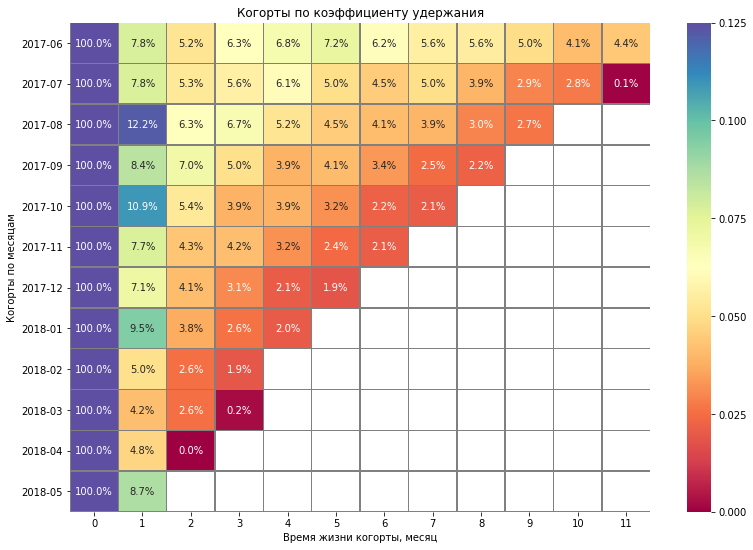

In [49]:
plt.figure(figsize=(13, 9))
sns.heatmap(retention, annot=True, fmt='.1%', vmin=0, vmax=0.125, 
            linewidths=0.5, linecolor='gray', cmap='Spectral', yticklabels=y_name)
plt.title('Когорты по коэффициенту удержания')
plt.xlabel('Время жизни когорты, месяц')
plt.ylabel('Когорты по месяцам');

**Retention Rate** - коэффициент удержания пользователя очень низкий.   
В первый же месяц когорты падает до 5-12%. и с каждым новым месяцем снижается еще больше, в каких-то случаях до 0.  
Первая когорта самая лояльная - больше всего коэф. удержания в среднем.

### Количество сессий в день на каждого пользователя<a name="count_sess"></a>

In [50]:
visits_df.sample() # вспомним данные

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_data,first_activ_data,first_activ_month,first_activ_week,cohort_lifetime
250953,desktop,2017-12-24 20:20:00,4,2017-12-24 20:19:00,11357616214229130624,2017,2017-12-01,2017-12-21,2017-12-24,2017-12-24,2017-12-01,2017-12-21,0


In [51]:
# расчитаем количество сессий в день
sessions_by_data = visits_df.groupby('start_ts_data').agg({'uid': ['count','nunique']})
sessions_by_data.columns = ['sessions', 'number_of_users']

# количество сессий на одного пользователя
sessions_by_data['sessions_per_user'] = sessions_by_data['sessions'] / sessions_by_data['number_of_users']
sessions_by_data.head()

,sessions,number_of_users,sessions_per_user
start_ts_data,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024


In [52]:
sessions_by_data.describe()

,sessions,number_of_users,sessions_per_user
count,364.000000,364.000000,364.000000
mean,987.362637,907.991758,1.082170
std,418.994796,370.513838,0.020876
min,1.000000,1.000000,1.000000
25%,635.500000,594.000000,1.070321
50%,1003.000000,921.000000,1.082488
75%,1280.000000,1173.000000,1.093876
max,4042.000000,3319.000000,1.217837


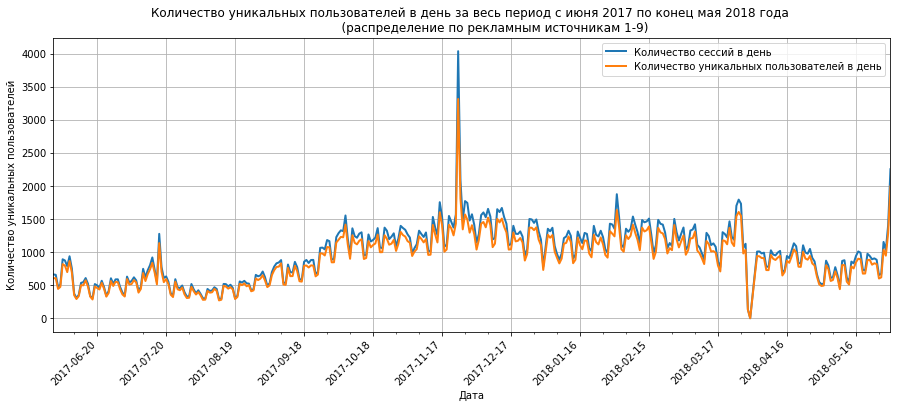

In [53]:
ax = visits_df.groupby('start_ts_data').agg({'uid': ['count','nunique']}).plot(figsize=(15, 6), lw=2)

plt.title('Количество уникальных пользователей в день за весь период с июня 2017 по конец мая 2018 года \n \
           (распределение по рекламным источникам 1-9)')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Количество уникальных пользователей')
plt.grid(axis='both')
plt.legend(['Количество сессий в день', 'Количество уникальных пользователей в день'], loc='best')

#  устанавливаем интервал основных и вспомогательных делений:
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10));

По графикам и описанию таблицы видно, что практически каждый пользователь заходит на сайт не более одного раза в день. Что видимо нормально для этой модели продаж. В среднем в день проходит около 1000 сессий, в предновогодние дни их было более 4000

### Длительность одной сессии<a name="dur_sess"></a>

In [54]:
visits_df.sample()

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_data,first_activ_data,first_activ_month,first_activ_week,cohort_lifetime
106281,desktop,2017-06-17 15:30:00,4,2017-06-17 15:08:00,17504080532392507904,2017,2017-06-01,2017-06-15,2017-06-17,2017-06-17,2017-06-01,2017-06-15,0


In [55]:
visits_df[['start_ts', 'end_ts']].describe()

,start_ts,end_ts
count,359400,359400
unique,224303,224760
top,2017-11-24 16:06:00,2017-11-24 16:51:00
freq,19,23
first,2017-06-01 00:01:00,2017-06-01 00:02:00
last,2018-05-31 23:59:00,2018-06-01 01:26:00


Время начала сессии и конца сессии представлены в таблице поминутно, поэтому длительность сессии можем рассчитывать с точностью до минуты.

In [56]:
visits_df['session_duration_minute'] = ((visits_df['end_ts'] - visits_df['start_ts']).dt.seconds)/60
visits_df['session_duration_minute'].describe()

count    359400.000000
mean         10.725108
std          16.938913
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max        1408.000000
Name: session_duration_minute, dtype: float64

Средняя сессия длилась около 10 мин., но при этом медиана всего 5 минут. Распределение не стандартное.    
Рассмотрим распределение в контексте устройств входа - настольного и мобильного.

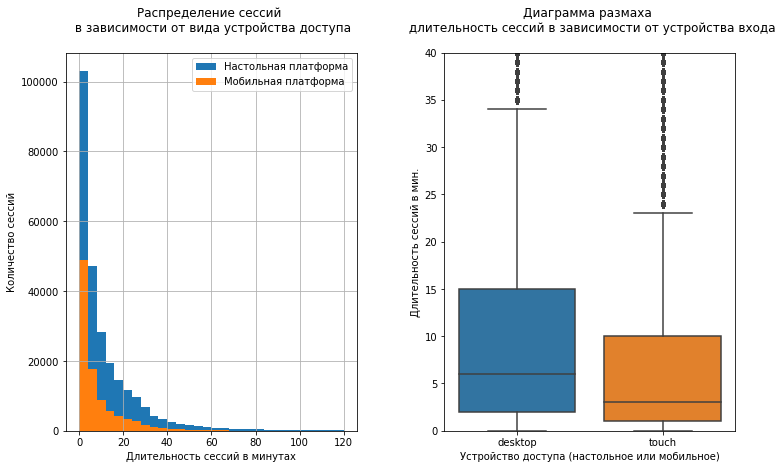

In [57]:
plt.figure(figsize=(12, 16))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(2, 2, 1)
visits_df.loc[visits_df.device == 'desktop']['session_duration_minute'].hist(
                                                        bins=30, range=(0, 120), label='Настольная платформа')
visits_df.loc[visits_df.device == 'touch']['session_duration_minute'].hist(
                                                        bins=30, range=(0, 120), label='Мобильная платформа')
plt.title('Распределение сессий \n в зависимости от вида устройства доступа\n  ')
plt.legend()
plt.xlabel('Длительность сессий в минутах')
plt.ylabel('Количество сессий')

plt.subplot(2, 2, 2)
plt.ylim(0, 40)
sns.boxplot(x="device", y="session_duration_minute", data=visits_df.sort_values(by='device'))
plt.title('Диаграмма размаха \n длительность сессий в зависимости от устройства входа\n  ')
plt.ylabel('Длительность сессий в мин.')
plt.xlabel('Устройство доступа (настольное или мобильное)');

In [58]:
visits_df.loc[visits_df.device == 'desktop']['session_duration_minute'].median()

6.0

In [59]:
visits_df.loc[visits_df.device == 'touch']['session_duration_minute'].median()

3.0

Распределение не нормальное поэтому определим моду в этих данных - самое часто встречающее значение. По графикам и расчетам видно, что сессии с мобильных устройств обычно короче чем на настольных.

In [60]:
visits_df['session_duration_minute'].mode()

0    1.0
dtype: float64

Общая самая типичная сессия по продолжительности 1 минута - может быть и достаточно для такого сервиса, лишь бы эти сессии были продающими. Судя по графикам тоже значение будет и для каждой платформы в отдельности. 

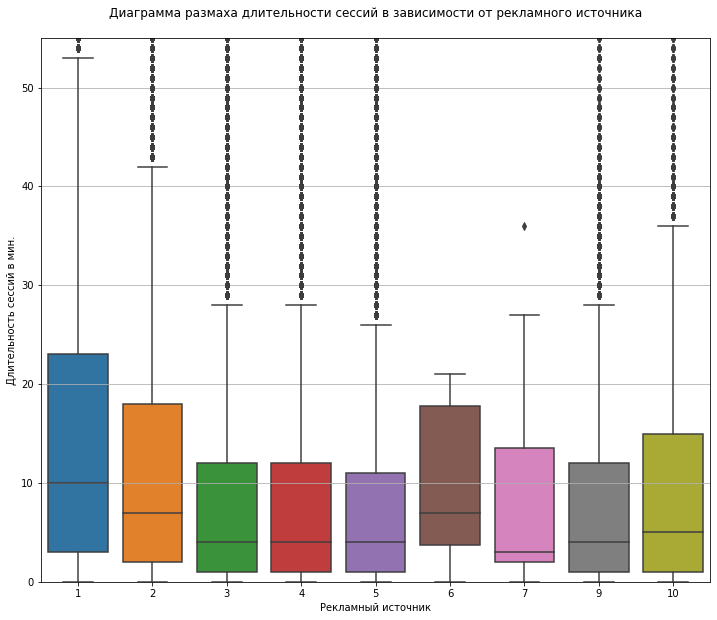

In [61]:
plt.figure(figsize=(12, 10))
plt.ylim(0, 55)
sns.boxplot(x="source_id", y="session_duration_minute", data=visits_df)
plt.title('Диаграмма размаха длительности сессий в зависимости от рекламного источника\n ')
plt.ylabel('Длительность сессий в мин.')
plt.xlabel('Рекламный источник')
plt.grid(axis='y');

Распределение длительности сессий по рекламным источникам показывает что источники 3,4,5 - самые короткие в среднем, при этом их больше всего. Пользователи приходящие с источников  1,2 остаются на сайте дольше всех.

В таблице есть данные о сессиях с нулевой продолжительностью - назовем их "обрывом" связи.

In [62]:
# количество сессий с длительностью 0 минут
len(visits_df[visits_df['session_duration_minute'] == 0]) 

35794

In [63]:
'В общем "обрывов" связи {:.2%}'.format(len(visits_df[visits_df['session_duration_minute'] == 0]) / len(visits_df))

'В общем "обрывов" связи 9.96%'

Рассмотрим "обрывы" связи в контексте устройств входа

In [64]:
duration_null = visits_df[visits_df['session_duration_minute'] == 0].pivot_table(
                                                                    index='start_ts_data', 
                                                                    columns='device',
                                                                    aggfunc=({'uid': 'count'}))
duration_null.columns = ['desktop', 'touch']
duration_null.head()

,desktop,touch
start_ts_data,,
2017-06-01,45,20
2017-06-02,36,26
2017-06-03,30,18
2017-06-04,40,23
2017-06-05,68,18


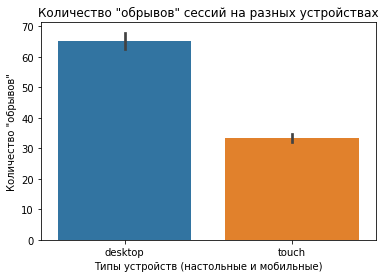

In [65]:
ax = sns.barplot(data=duration_null)
ax.set_title('Количество "обрывов" сессий на разных устройствах')
ax.set(ylabel='Количество "обрывов"')
ax.set(xlabel='Типы устройств (настольные и мобильные)');

"Обрывов" больше на настольных устройствах почти в 2 раза,  но их и по количеству больше в 2 раза.     
Посмотрим какое отношение "обрывов" к успешным сессиям

In [66]:
duration_not_null = visits_df[visits_df['session_duration_minute'] != 0].pivot_table(
                                                                    index='start_ts_data', 
                                                                    columns='device',
                                                                    aggfunc=({'uid': 'count'}))
duration_not_null.columns = ['desktop', 'touch']
duration_not_null.head()

,desktop,touch
start_ts_data,,
2017-06-01,456.0,143.0
2017-06-02,462.0,134.0
2017-06-03,299.0,130.0
2017-06-04,309.0,138.0
2017-06-05,625.0,182.0


In [67]:
print('Соотношение "обрывов" к состоявшимся сессиям на настольных платформах = {:.2%}\n'
'Соотношение "обрывов" к состоявшимся сессиям на мобильных платформах = {:.2%}'.format(
    duration_null.desktop.sum()/duration_not_null.desktop.sum(),
    duration_null.touch.sum()/duration_not_null.touch.sum()))

Соотношение "обрывов" к состоявшимся сессиям на настольных платформах = 9.92%
Соотношение "обрывов" к состоявшимся сессиям на мобильных платформах = 14.29%


Получается что на настольных платформах реже случаются нулевые сессии.

## Продажи<a name="sales"></a>

### Продолжительность сессии первой покупки<a name="sales_first"></a>

Продолжительность сессии первой покупки определим по двум базам. Из продаж получим дату первого заказа. Из визитов получим дату первого визита. Объединив две базы (по пользователю) будем оперировать разницей по времени между первым посещением и датой первой покупки

In [68]:
visits_df.sample() # данные по визитам

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_data,first_activ_data,first_activ_month,first_activ_week,cohort_lifetime,session_duration_minute
83862,desktop,2017-10-26 09:02:00,5,2017-10-26 08:41:00,11628313771105581945,2017,2017-10-01,2017-10-26,2017-10-26,2017-10-26,2017-10-01,2017-10-26,0,21.0


In [69]:
orders_df.head() # данные по покупкам

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [70]:
# дата первого заказа
first_order = orders_df.groupby('uid')['buy_ts'].min() 
first_order.name = 'first_buy_ts'
first_order.head()

uid
313578113262317    2018-01-03 21:51:00
1575281904278712   2017-06-03 10:13:00
2429014661409475   2017-10-11 18:33:00
2464366381792757   2018-01-28 15:54:00
2551852515556206   2017-11-24 10:14:00
Name: first_buy_ts, dtype: datetime64[ns]

In [71]:
# дата первого посещения
first_visits = visits_df.groupby('uid')['start_ts'].min() 
first_visits.name = 'first_activ_data'
first_visits.head()

uid
11863502262781    2018-03-01 17:27:00
49537067089222    2018-02-06 15:55:00
297729379853735   2017-06-07 18:47:00
313578113262317   2017-09-18 22:49:00
325320750514679   2017-09-30 14:29:00
Name: first_activ_data, dtype: datetime64[ns]

In [72]:
# данные объединненых таблиц - первое посещение + первая покупка
start_buy = pd.merge(first_order, first_visits, on='uid')
start_buy.head()

,first_buy_ts,first_activ_data
uid,,
313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


In [73]:
# находим время в минутах затраченное на первую покупку
start_buy['min_on_first_buy'] = (start_buy.first_buy_ts - start_buy.first_activ_data).dt.seconds/60
start_buy.head()

,first_buy_ts,first_activ_data,min_on_first_buy
uid,,,
313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,1382.0
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,79.0
2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,1184.0
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.0


In [74]:
start_buy['min_on_first_buy'].describe()

count    36523.000000
mean       249.164691
std        429.742785
min          0.000000
25%          4.000000
50%         16.000000
75%        252.000000
max       1439.000000
Name: min_on_first_buy, dtype: float64

In [75]:
start_buy['min_on_first_buy'].mode()

0    1.0
dtype: float64

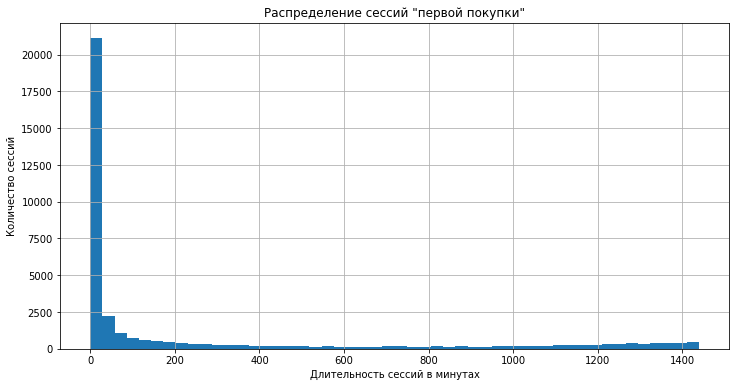

In [76]:
plt.figure(figsize=(12, 6))
start_buy['min_on_first_buy'].hist(bins=50)
plt.title('Распределение сессий "первой покупки"')
plt.xlabel('Длительность сессий в минутах')
plt.ylabel('Количество сессий');

Распределение опять ненормальное и точнее всего типичное время покупки отражает значение моды = 1 минута. Собственно неплохо - большинство пользователей смогли быстро найти что им нужно и оформить заказ. 

### Количество покупок  за период<a name="sales_count"></a>

In [77]:
orders_df.sample() #данные по покупкам

,buy_ts,revenue,uid
28824,2018-01-10 16:13:00,0.43,13924368059006442720


In [78]:
# определим даты покупок - день, неделя, месяц
orders_df['data'] = orders_df['buy_ts'].astype('datetime64[D]')
orders_df['week'] = orders_df['buy_ts'].astype('datetime64[W]')
orders_df['month'] = orders_df['buy_ts'].astype('datetime64[M]')
orders_df.head()

,buy_ts,revenue,uid,data,week,month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01


**Построим данные и графики по дням, неделям, и месяцам продаж и посмотрим картину целиком**

In [79]:
# данные о продажах по дням
buy_by_data = orders_df.groupby(['data']).agg({'uid': ['count','nunique'], 'revenue':'sum'})
buy_by_data.columns = ['session_buy', 'uid_count', 'revenue_sum']
buy_by_data['revenue_mean'] = buy_by_data['revenue_sum'] / buy_by_data['uid_count'] # данные о среднем чеке
buy_by_data['buy_per_user'] = buy_by_data['session_buy'] / buy_by_data['uid_count'] # данные о покупках на одного клиента.
buy_by_data.head()

,session_buy,uid_count,revenue_sum,revenue_mean,buy_per_user
data,,,,,
2017-06-01,96,86,389.46,4.528605,1.116279
2017-06-02,111,101,324.11,3.209010,1.099010
2017-06-03,67,61,166.48,2.729180,1.098361
2017-06-04,66,59,195.21,3.308644,1.118644
2017-06-05,161,146,441.49,3.023904,1.102740


In [80]:
buy_by_data.describe()

,session_buy,uid_count,revenue_sum,revenue_mean,buy_per_user
count,364.000000,364.000000,364.000000,364.000000,364.000000
mean,138.502747,127.879121,692.464835,5.330931,1.079360
std,76.858480,69.021031,503.309340,2.223256,0.037169
min,1.000000,1.000000,3.420000,2.247692,1.000000
25%,82.750000,78.000000,378.907500,4.227089,1.056728
50%,136.000000,124.500000,596.850000,4.886094,1.077850
75%,177.000000,163.000000,869.780000,5.796437,1.097596
max,814.000000,701.000000,4661.330000,32.147103,1.220974


В среднем в день совершают покупки 127 пользователей, каждый покупатель в среднем покупает 1 раз в день.

In [81]:
# данные о продажах по неделям
buy_by_week = orders_df.groupby(['week']).agg({'uid': ['count','nunique'], 'revenue':'sum'})
buy_by_week.columns = ['session_buy', 'uid_count', 'revenue_sum']
buy_by_week['revenue_mean'] = buy_by_week['revenue_sum'] / buy_by_week['uid_count'] # расчет среднего чека
buy_by_week['buy_per_user'] = buy_by_week['session_buy'] / buy_by_week['uid_count'] # данные о покупках на одного клиента.
buy_by_week.head()

,session_buy,uid_count,revenue_sum,revenue_mean,buy_per_user
week,,,,,
2017-06-01,896,774,2546.66,3.290258,1.157623
2017-06-08,525,478,2536.51,5.306506,1.098326
2017-06-15,341,310,1527.33,4.926871,1.100000
2017-06-22,441,396,2099.22,5.301061,1.113636
2017-06-29,461,416,2449.82,5.888990,1.108173


In [82]:
buy_by_week.describe()

,session_buy,uid_count,revenue_sum,revenue_mean,buy_per_user
count,53.000000,53.000000,53.000000,53.000000,53.000000
mean,951.226415,818.094340,4755.796226,5.776118,1.156124
std,405.229880,333.067056,2210.315863,1.145356,0.039690
min,319.000000,264.000000,1442.060000,3.290258,1.070053
25%,631.000000,571.000000,2770.330000,4.987772,1.127619
50%,972.000000,850.000000,4446.760000,5.534145,1.155090
75%,1214.000000,1051.000000,6386.730000,6.150030,1.183865
max,2120.000000,1696.000000,11041.610000,8.984223,1.256270


В среднем в неделю совершают покупки 818 пользователей, каждый покупатель в среднем покупает 1 раз в неделю.

In [83]:
# данные о продажах по месяцам
buy_by_month = orders_df.groupby(['month']).agg({'uid': ['count','nunique'], 'revenue':'sum'})
buy_by_month.columns = ['session_buy', 'uid_count', 'revenue_sum']
buy_by_month['revenue_mean'] = buy_by_month['revenue_sum'] / buy_by_month['uid_count'] # средний чек
buy_by_month['buy_per_user'] = buy_by_month['session_buy'] / buy_by_month['uid_count'] # данные о покупках на одного клиента.
buy_by_month.head()

,session_buy,uid_count,revenue_sum,revenue_mean,buy_per_user
month,,,,,
2017-06-01,2354,2023,9557.49,4.724414,1.163618
2017-07-01,2363,1984,12539.47,6.320297,1.191028
2017-08-01,1807,1472,8758.78,5.950258,1.227582
2017-09-01,3387,2750,18345.51,6.671095,1.231636
2017-10-01,5679,4675,27987.70,5.986674,1.214759


In [84]:
buy_by_month.describe()

,session_buy,uid_count,revenue_sum,revenue_mean,buy_per_user
count,13.000000,13.000000,13.000000,13.000000,13.000000
mean,3878.076923,3155.307692,19389.015385,5.866514,1.205823
std,1858.113401,1477.043860,9962.071481,1.014569,0.068470
min,1.000000,1.000000,3.420000,3.420000,1.000000
25%,2363.000000,2023.000000,12539.470000,5.851010,1.192784
50%,4346.000000,3544.000000,19417.130000,5.986674,1.226298
75%,5326.000000,4258.000000,27069.930000,6.320297,1.240254
max,6218.000000,4942.000000,36388.600000,7.363132,1.273858


In [85]:
'Cреднее количество покупателей за первые 6 месяцев = {}'.format(buy_by_month['uid_count'].head(6).mean())

'Cреднее количество покупателей за первые 6 месяцев = 2908.5'

In [86]:
'Средний покупатель за полгода покупает {} раз'.format((6 * buy_by_month['buy_per_user'].mean()).round())

'Средний покупатель за полгода покупает 7.0 раз'

В среднем в месяц совершают покупки 3155 пользователей, каждый покупатель в среднем покупает 1 раз в месяц.    
За первые 6 месяцев с 06-2017 по 11.2017 среднее число покупателей в месяц - 2908.   
Средний покупатель за полгода делает покупки 7 раз

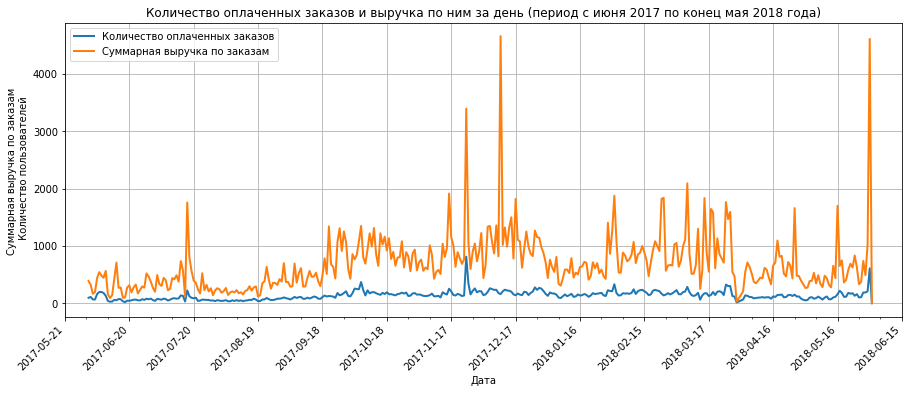

In [87]:
ax = buy_by_data['session_buy'].plot(figsize=(15, 6), lw=2, xlim=('2017-05-21', '2018-06-15'))
ax1 = buy_by_data['revenue_sum'].plot(figsize=(15, 6), lw=2, ax=ax, xlim=('2017-05-21', '2018-06-15'))

plt.title('Количество оплаченных заказов и выручка по ним за день (период с июня 2017 по конец мая 2018 года)')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Суммарная выручка по заказам \n Количество пользователей')
plt.grid(axis='both')
plt.legend(['Количество оплаченных заказов', 'Суммарная выручка по заказам'], loc='best')

#  устанавливаем интервал основных и вспомогательных делений:
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

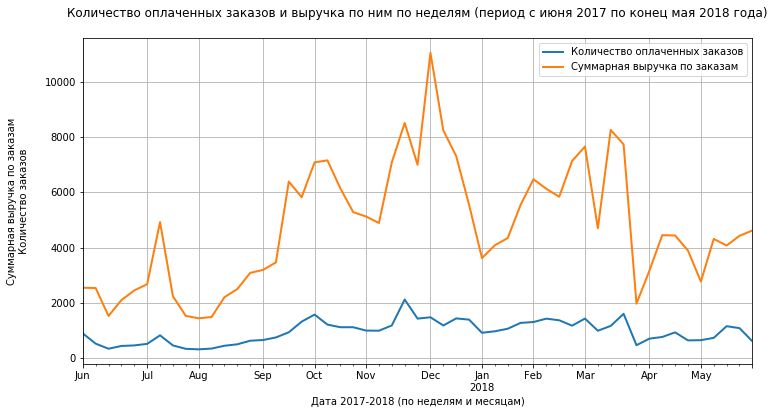

In [88]:
ax = buy_by_week['session_buy'].plot(figsize=(12, 6), lw=2)
ax1 = buy_by_week['revenue_sum'].plot(figsize=(12, 6), lw=2, ax=ax)

plt.title('Количество оплаченных заказов и выручка по ним по неделям (период с июня 2017 по конец мая 2018 года)\n ')
plt.xlabel('Дата 2017-2018 (по неделям и месяцам)')
plt.ylabel('Суммарная выручка по заказам\n Количество заказов \n' )
plt.grid(axis='both')
plt.legend(['Количество оплаченных заказов', 'Суммарная выручка по заказам'], loc='best');

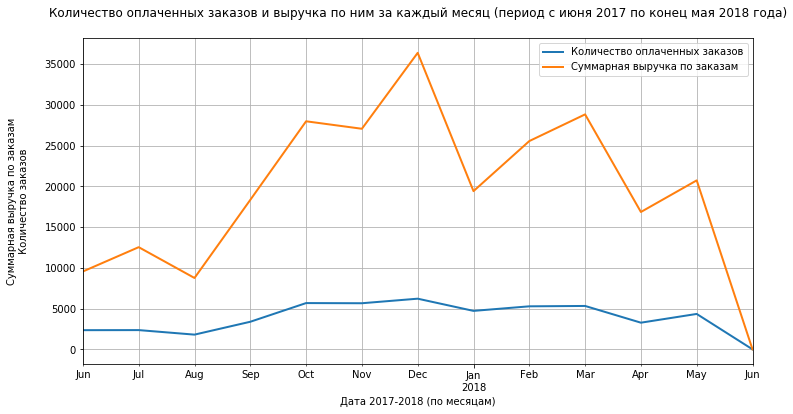

In [89]:
ax = buy_by_month['session_buy'].plot(figsize=(12, 6), lw=2)
ax1 = buy_by_month['revenue_sum'].plot(figsize=(12, 6), lw=2, ax=ax)

plt.title('Количество оплаченных заказов и выручка по ним за каждый месяц (период с июня 2017 по конец мая 2018 года)\n')
plt.xlabel('Дата 2017-2018 (по месяцам)')
plt.ylabel('Суммарная выручка по заказам\n Количество заказов \n' )
plt.grid(which='both', axis='both')
plt.legend(['Количество оплаченных заказов', 'Суммарная выручка по заказам'], loc='best');

Судя по полученным данным и графикам, рост количества сессиий в августе 2017 с пиком в новый год также отразился на количестве продажах и выручке. Заметно что в ноябре-декабре 2017 стали покупать не сильно чаще но больше - объем выручки вырос сильнее чем объем заказов.

### Средний чек<a name="rev_per_uid"></a>

**По уже проведенным выше расчетам посмотрим описание данных, построим графики и оценим картину целиком**

In [90]:
# описание данных по среднему чеку по дням
buy_by_data.revenue_mean.describe()

count    364.000000
mean       5.330931
std        2.223256
min        2.247692
25%        4.227089
50%        4.886094
75%        5.796437
max       32.147103
Name: revenue_mean, dtype: float64

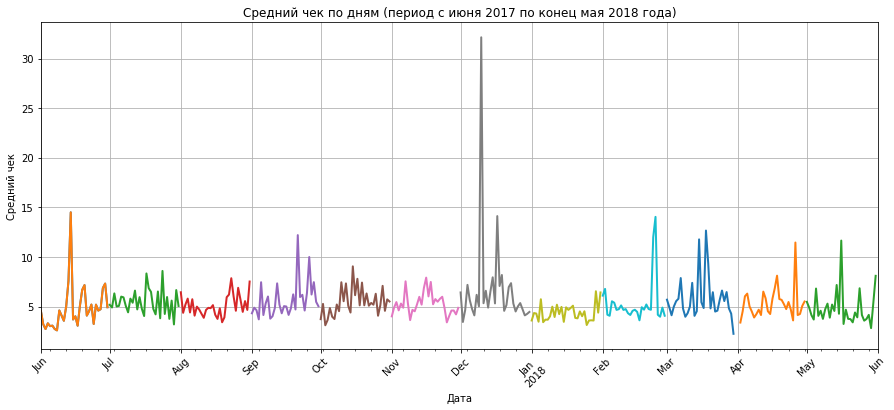

In [91]:
ax = buy_by_data.revenue_mean.resample("M").plot(figsize=(15, 6), lw=2)

plt.title('Cредний чек по дням (период с июня 2017 по конец мая 2018 года)')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Cредний чек')
plt.grid(axis='both');

In [92]:
# описание данных по среднему чеку по неделям
buy_by_week.revenue_mean.describe()

count    53.000000
mean      5.776118
std       1.145356
min       3.290258
25%       4.987772
50%       5.534145
75%       6.150030
max       8.984223
Name: revenue_mean, dtype: float64

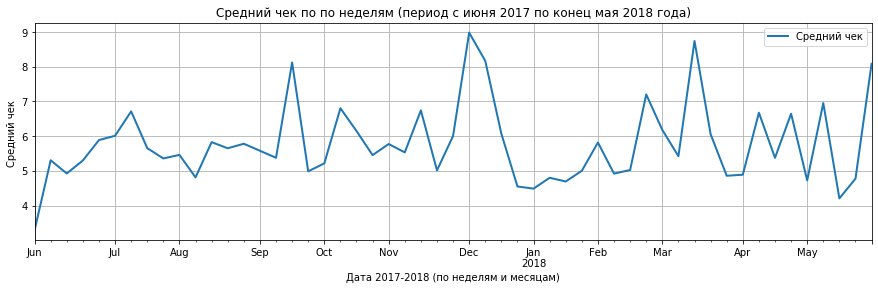

In [93]:
ax = buy_by_week.revenue_mean.plot(figsize=(15, 4), lw=2)

plt.title('Cредний чек по по неделям (период с июня 2017 по конец мая 2018 года)')
plt.xlabel('Дата 2017-2018 (по неделям и месяцам)')
plt.ylabel('Cредний чек ')
plt.grid(axis='both')
plt.legend(['Cредний чек'], loc='best');

In [94]:
# описание данных по среднему чеку по месяцам
buy_by_month.revenue_mean.describe()

count    13.000000
mean      5.866514
std       1.014569
min       3.420000
25%       5.851010
50%       5.986674
75%       6.320297
max       7.363132
Name: revenue_mean, dtype: float64

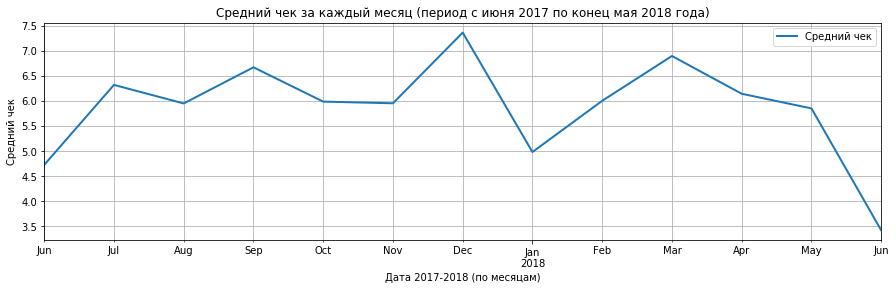

In [95]:
ax = buy_by_month.revenue_mean.plot(figsize=(15, 4), lw=2)

plt.title('Средний чек за каждый месяц (период с июня 2017 по конец мая 2018 года)')
plt.xlabel('Дата 2017-2018 (по месяцам)')
plt.ylabel('Средний чек')
plt.grid(which='both', axis='both')
plt.legend(['Средний чек'], loc='best');

**Построим объединненный график средних чеков по периодам**

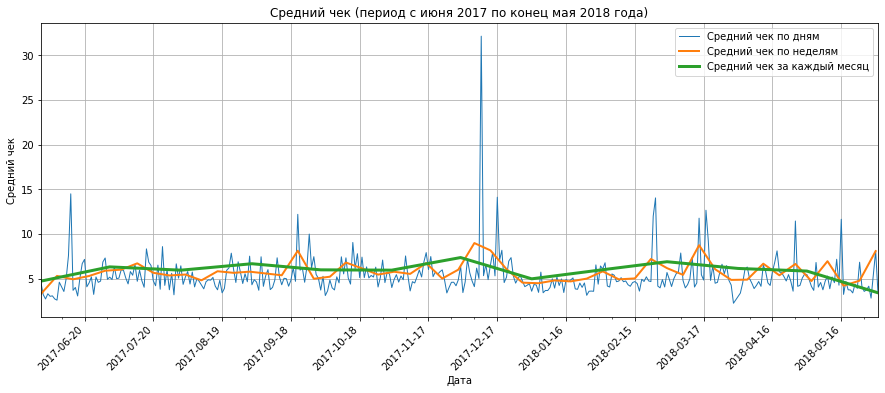

In [96]:
ax = buy_by_data.revenue_mean.plot(figsize=(15, 6), lw=1)
ax1 = buy_by_week.revenue_mean.plot(figsize=(15, 6), lw=2)
ax2 = buy_by_month.revenue_mean.plot(figsize=(15, 6), lw=3)

plt.title('Cредний чек (период с июня 2017 по конец мая 2018 года)')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Cредний чек')
plt.grid(axis='both')
plt.legend(['Cредний чек по дням', 'Cредний чек по неделям', 'Cредний чек за каждый месяц'], loc='best')

#  устанавливаем интервал основных и вспомогательных делений:
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

По полученным данным и по графикам видно, что средний чек по всем периодам колеблется в "среднем" около 4,8-5 ед. Как и по продажам в целом, поведение кривой схоже - средний чек заметно выше в новогодний период. Падение в январе. Есть всплеск середине июня 2017, в конце февраля 2018 (с чего бы это).

***Полученные данные не отражают другой информации - это средний чек повторных покупок или новых пользователей. Проведем когортный анализ среднего чека.***

### Когортный анализ среднего чека по месяцам<a name="rev_per_uid_m"></a>

In [97]:
orders_df.head() # данные по покупкам

,buy_ts,revenue,uid,data,week,month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01


In [98]:
# выделим певый месяц покупки
first_orders = orders_df.groupby('uid').agg({'month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_month']
first_orders.head()

,uid,first_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [99]:
first_orders.shape # по количеству уникальных пользователей

(36523, 2)

In [100]:
# данные по месяцу первой покупки объединим с основной таблицей
orders_first_month = pd.merge(orders_df, first_orders, on='uid')
orders_first_month.head()

,buy_ts,revenue,uid,data,week,month,first_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01


In [101]:
orders_first_month.shape # общий размер исходной базы по покупкам

(50415, 7)

In [102]:
# определим размеры когорт
cohorts = first_orders.groupby('first_month').agg({'uid':'count'}).reset_index()
cohorts.columns = ['first_month', 'uid_cohorts']
cohorts

,first_month,uid_cohorts
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [103]:
# расчитаем выручку когорт
cohort_sizes_month = orders_first_month.groupby(['first_month', 'month']).agg({'revenue':'sum', 'uid':'nunique'}).reset_index()
cohort_sizes_month.columns = ['first_month', 'month', 'revenue_sum', 'uid_count']
cohort_sizes_month.head()

,first_month,month,revenue_sum,uid_count
0,2017-06-01,2017-06-01,9557.49,2023
1,2017-06-01,2017-07-01,981.82,61
2,2017-06-01,2017-08-01,885.34,50
3,2017-06-01,2017-09-01,1931.30,54
4,2017-06-01,2017-10-01,2068.58,88


In [104]:
# расчет среднего чека когорты на уникального пользователя
cohort_sizes_month['revenue_per_uid'] = cohort_sizes_month['revenue_sum'] / cohort_sizes_month['uid_count']

# расчет времени "жизни" когорты
cohort_sizes_month['age'] = (cohort_sizes_month['month'] - cohort_sizes_month['first_month']) / np.timedelta64(1,'M')
cohort_sizes_month['age'] = cohort_sizes_month['age'].round().astype('int')
cohort_sizes_month.head()

,first_month,month,revenue_sum,uid_count,revenue_per_uid,age
0,2017-06-01,2017-06-01,9557.49,2023,4.724414,0
1,2017-06-01,2017-07-01,981.82,61,16.095410,1
2,2017-06-01,2017-08-01,885.34,50,17.706800,2
3,2017-06-01,2017-09-01,1931.30,54,35.764815,3
4,2017-06-01,2017-10-01,2068.58,88,23.506591,4


In [105]:
# объединненая таблица когорт по месяцам и размерам когорт
report = pd.merge(cohort_sizes_month, cohorts, on='first_month')
report.head()

,first_month,month,revenue_sum,uid_count,revenue_per_uid,age,uid_cohorts
0,2017-06-01,2017-06-01,9557.49,2023,4.724414,0,2023
1,2017-06-01,2017-07-01,981.82,61,16.095410,1,2023
2,2017-06-01,2017-08-01,885.34,50,17.706800,2,2023
3,2017-06-01,2017-09-01,1931.30,54,35.764815,3,2023
4,2017-06-01,2017-10-01,2068.58,88,23.506591,4,2023


In [106]:
report['retention'] = report['uid_count'] / report['uid_cohorts']    # расчет retention
report.head()

,first_month,month,revenue_sum,uid_count,revenue_per_uid,age,uid_cohorts,retention
0,2017-06-01,2017-06-01,9557.49,2023,4.724414,0,2023,1.000000
1,2017-06-01,2017-07-01,981.82,61,16.095410,1,2023,0.030153
2,2017-06-01,2017-08-01,885.34,50,17.706800,2,2023,0.024716
3,2017-06-01,2017-09-01,1931.30,54,35.764815,3,2023,0.026693
4,2017-06-01,2017-10-01,2068.58,88,23.506591,4,2023,0.043500


In [107]:
report.shape

(79, 8)

In [108]:
# сводная таблица когорт по изменению среднего чека со временем 
report_rev_per_uid = report.pivot_table(index='first_month', 
                                        columns='age', 
                                        values='revenue_per_uid', 
                                        aggfunc='mean').round(2)
report_rev_per_uid.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_month,,,,,,,,,,,,
2017-06-01,4.72,16.1,17.71,35.76,23.51,22.21,31.01,25.03,19.3,27.23,25.68,9.8
2017-07-01,6.01,12.4,21.04,10.79,6.94,7.9,6.42,6.99,7.38,12.86,11.51,
2017-08-01,5.28,11.15,11.85,12.18,16.92,12.14,9.62,12.61,21.07,8.31,,
2017-09-01,5.64,22.19,13.45,138.67,19.88,26.1,27.44,16.96,11.04,,,
2017-10-01,5.00,11.29,6.75,7.41,7.07,7.26,6.57,7.48,,,,
2017-11-01,5.15,7.34,6.79,12.51,7.46,4.58,7.56,,,,,
2017-12-01,4.74,7.82,39.37,48.14,27.43,23.52,,,,,,
2018-01-01,4.14,8.72,12.37,11.2,4.7,,,,,,,
2018-02-01,4.16,8.61,4.94,6.94,,,,,,,,


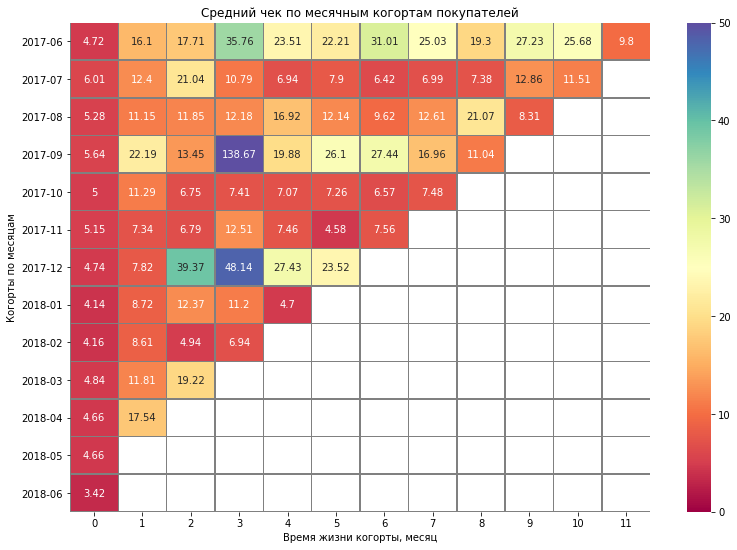

In [109]:
# подготовим данные для шкалы с датами когорт
y_name_month = report['first_month'].unique().astype('datetime64[M]')

plt.figure(figsize=(13, 9))
sns.heatmap(report_rev_per_uid, annot=True, vmin=0, vmax=50, fmt="g",
            linewidths=0.5, linecolor='gray', cmap='Spectral', yticklabels=y_name_month)
plt.title('Cредний чек по месячным когортам покупателей')
plt.xlabel('Время жизни когорты, месяц')
plt.ylabel('Когорты по месяцам');

**По диаграмме видно, что**:
- Средний чек уникального покупателя для всех когорт растет (за редким исключением)
- Поскольку мы помним что коэффициент удержания по когортам снижается с каждым месяцем (и очень сильно), а средний чек расчитанный помесячно в пределах 5 ед., получается что лояльные пользователи когорты (те немногие что остались) тратят больше в каждом последующем месяце.
- Первая, июньская, когорта самая стабильная - показывает высокие средние чеки в процессе всей "жизни". 
- Данные по среднему чеку сентябрьской и декабрьской когорте имеют выбросы в предпраздничные периоды (новый год, 8 марта) повторяющие общую картину продаж. 
- Можно говорить о том что в этих когортах (июнь, сентябрь, декабрь) самые лояльные пользователи покупающие больше и чаще.

**Рассчитаем средний чек покупки каждой когорты во времени**

In [110]:
# расчитаем выручку когорт
cohort_sizes = orders_first_month.groupby(['first_month', 'month']).agg({'revenue':'sum', 'uid':'count'}).reset_index()
cohort_sizes.columns = ['first_month', 'month', 'revenue_sum', 'uid_count']
cohort_sizes.head()

,first_month,month,revenue_sum,uid_count
0,2017-06-01,2017-06-01,9557.49,2354
1,2017-06-01,2017-07-01,981.82,177
2,2017-06-01,2017-08-01,885.34,174
3,2017-06-01,2017-09-01,1931.30,226
4,2017-06-01,2017-10-01,2068.58,292


In [111]:
# расчет среднего чека покупки в когорте
cohort_sizes['revenue_per_uid'] = cohort_sizes['revenue_sum'] / cohort_sizes['uid_count']
cohort_sizes['age'] = (cohort_sizes['month'] - cohort_sizes['first_month']) / np.timedelta64(1,'M')
cohort_sizes['age'] = cohort_sizes['age'].round().astype('int')
cohort_sizes.head()

,first_month,month,revenue_sum,uid_count,revenue_per_uid,age
0,2017-06-01,2017-06-01,9557.49,2354,4.060106,0
1,2017-06-01,2017-07-01,981.82,177,5.547006,1
2,2017-06-01,2017-08-01,885.34,174,5.088161,2
3,2017-06-01,2017-09-01,1931.30,226,8.545575,3
4,2017-06-01,2017-10-01,2068.58,292,7.084178,4


In [112]:
# сводная таблица когорт по изменению среднего чека со временем 
report_rev_per_uid_1 = cohort_sizes.pivot_table(index='first_month', 
                                        columns='age', 
                                        values='revenue_per_uid', 
                                        aggfunc='mean').round(2)
report_rev_per_uid_1.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_month,,,,,,,,,,,,
2017-06-01,4.06,5.55,5.09,8.55,7.08,6.83,6.97,6.76,5.28,8.01,12.04,6.04
2017-07-01,5.29,6.45,9.99,6.64,4.72,3.66,3.79,5.45,5.35,11.79,5.65,
2017-08-01,4.72,5.99,6.28,6.62,7.96,6.27,5.89,7.11,8.7,5.6,,
2017-09-01,4.97,13.17,8.35,62.57,15.43,15.32,16.77,11.21,7.79,,,
2017-10-01,4.37,7.41,5.13,5.59,5.1,5.07,4.28,4.01,,,,
2017-11-01,4.37,4.1,4.47,6.28,4.44,3.73,4.6,,,,,
2017-12-01,4.11,4.23,20.07,26.08,15.95,14.11,,,,,,
2018-01-01,3.69,4.44,6.45,7.52,2.71,,,,,,,
2018-02-01,3.71,4.58,3.45,3.87,,,,,,,,


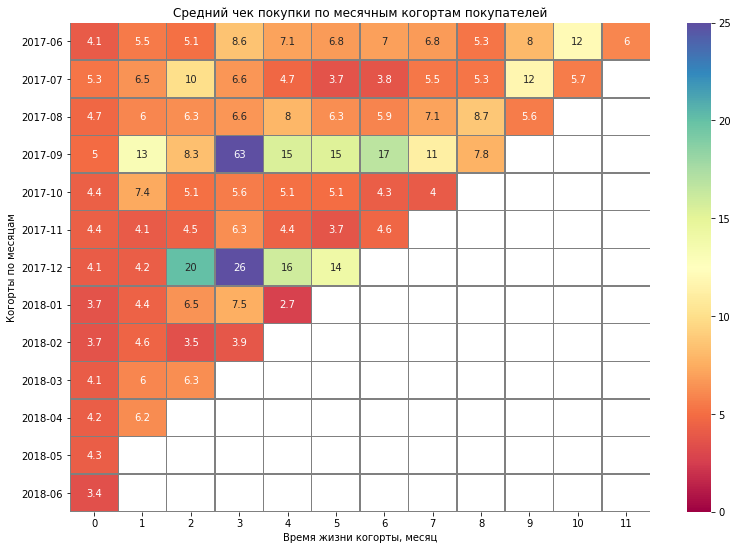

In [113]:
plt.figure(figsize=(13, 9))
sns.heatmap(report_rev_per_uid_1, annot=True, vmin=0, vmax=25, 
            linewidths=0.5, linecolor='gray', cmap='Spectral', yticklabels=y_name_month)
plt.title('Cредний чек покупки по месячным когортам покупателей')
plt.xlabel('Время жизни когорты, месяц')
plt.ylabel('Когорты по месяцам');

**По диаграмме видно, что**:
- Средний чек покупки для для большинства когорт сохраняется в пределах 4-6 ед. или 6-8 ед.(что выше в среднем)
- Средний чек в основном растет с продолжительностью жизни когорты. Поскольку мы помним что коэффициент удержания по когортам снижается с каждым месяцем (и очень сильно), а средний чек расчитанный помесячно тоже находится в пределах 5 ед., получается что лояльные пользователи когорты тратят больше в каждом последующем месяце.
- Данные по среднему чеку по сентябрьской и декабрьской когорте имеют выбросы в предпраздничные периоды (новый год, 8 марта) повторяющие общую картину продаж. 
- Можно говорить о том что в этих когортах (июнь, сентябрь, декабрь) самые лояльные пользователи покупающие больше и чаще.

**Получим картину активности пользователей в когорте - сколько раз пользователи когорты покупали в месяц**<a name="rev_per_uid_m_activ"></a>

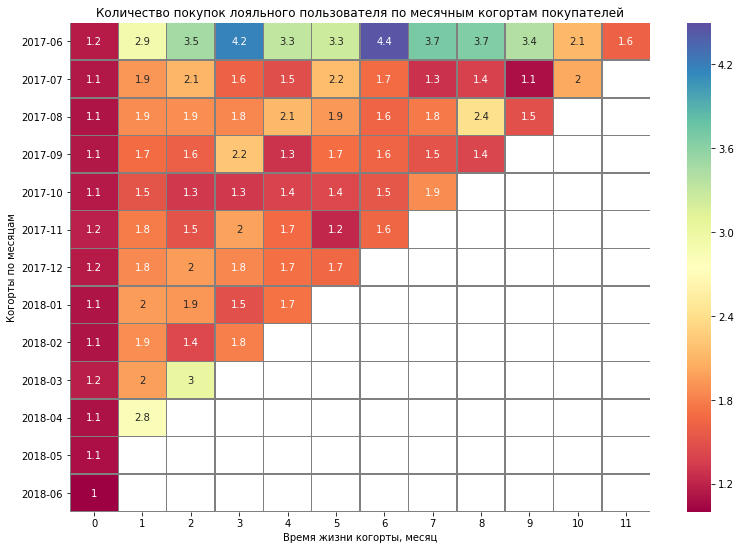

In [114]:
# разделим данные среднего чека на каждого пользователя когорты на данные среднего чека покупок
activ_uid = report_rev_per_uid / report_rev_per_uid_1 

plt.figure(figsize=(13, 9))
sns.heatmap(activ_uid, annot=True, vmin=1, vmax=4.5, 
            linewidths=0.5, linecolor='gray', cmap='Spectral', yticklabels=y_name_month)
plt.title('Количество покупок лояльного пользователя по месячным когортам покупателей')
plt.xlabel('Время жизни когорты, месяц')
plt.ylabel('Когорты по месяцам');

- Самые активные пользователи первой (июньской) когорты они покупают чаще других 3-4 раза в месяц в среднем
- В остальных когортах покупки повторяются у каждого второго в среднем - показатель покупок 1,5-2

## Выручка и доход с каждого пользователя (LTV)<a name="ltv"></a>

Перед началом расчетов оценим те данные которые нам известны - совокупный доход от продаж, затраты (маркетинговые - других  нет).     
Расчитаем получаем ли мы прибыль по итогу за год или убыток.

In [115]:
orders_df.head() # данные по доходам

,buy_ts,revenue,uid,data,week,month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01


In [116]:
costs_df.head() # данные по затратам

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [117]:
orders_df.revenue.sum() - costs_df.costs.sum() # убыток за период

-77074.42000000001

***Простым расчетом получаем что деятельность компании, по известным нам данным, убыточна.***

Проведем когортный анализ по показателю LTV - пожизненная ценность клиента, или проще - доход от клиента за определенный период

### Расчет LTV по выручке<a name="ltv_marketing"></a> 

In [118]:
orders_df.head()   # база по покупкам

,buy_ts,revenue,uid,data,week,month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01


In [119]:
# определяем месяц первой покупки 
first_orders = orders_df.groupby('uid').agg({'month': 'min'}).reset_index() 
first_orders.columns = ['uid', 'first_month']
first_orders.head()

,uid,first_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [120]:
# составляем когорты по месяцу первой покупки
cohort_sizes = first_orders.groupby('first_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_month', 'uid_count']
cohort_sizes.head()

,first_month,uid_count
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [121]:
# объединяем таблицы заказов с датой первой покупки для каждого пользователя
orders_first_month = pd.merge(orders_df, first_orders, on='uid')
orders_first_month.head()

,buy_ts,revenue,uid,data,week,month,first_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01


In [122]:
# таблица выручки по месяцу первой покупки и месяцу каждой покупки.
cohorts = orders_first_month.groupby(['first_month','month']).agg({'revenue': 'sum'}).reset_index()
cohorts.head()

,first_month,month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [123]:
# объединяем по месяцу первой покупки данные кол-ву покупапетелей и выручке  
report_ltv = pd.merge(cohort_sizes, cohorts, on='first_month')
report_ltv.head()

,first_month,uid_count,month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


In [124]:
# расчитаем возраст когорт и LTV
report_ltv['age'] = (report_ltv['month'] - report_ltv['first_month']) / np.timedelta64(1, 'M')
report_ltv['age'] = report_ltv['age'].round().astype('int')
report_ltv['ltv'] = report_ltv['revenue'] / report_ltv['uid_count']  #маржа принимается как 1
report_ltv.head()

,first_month,uid_count,month,revenue,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531


In [125]:
result_ltv = report_ltv.pivot_table(
                        index='first_month', 
                        columns='age', 
                        values='ltv', 
                        aggfunc='mean').round(2)

# LTV накопительная величина поэтому для корректной визуализации результатов
# применяем кумулятивную сумму.
result_ltv.cumsum(axis=1).fillna('')     

age,0,1,2,3,4,5,6,7,8,9,10,11
first_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.4,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.37,7.58,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,,,,,
2017-12-01,4.74,5,5.93,7,7.31,7.65,,,,,,
2018-01-01,4.14,4.43,4.73,4.87,4.93,,,,,,,
2018-02-01,4.16,4.44,4.52,4.59,,,,,,,,


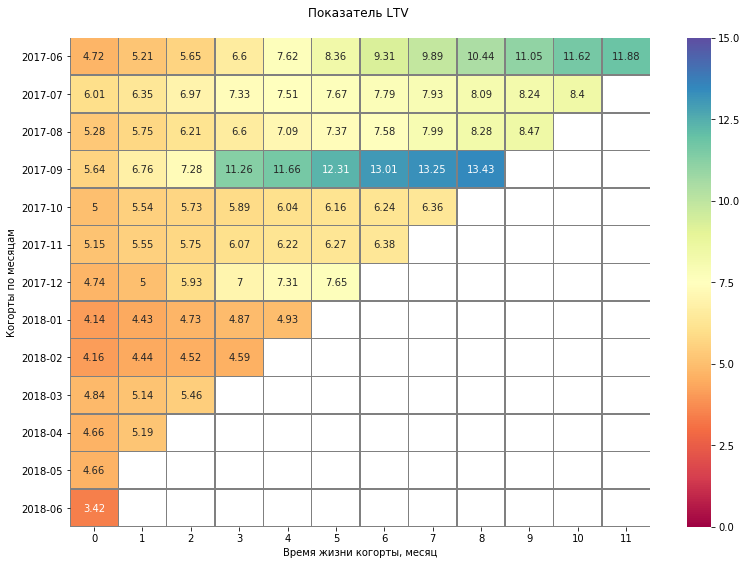

In [126]:
plt.figure(figsize=(13, 9))
sns.heatmap(result_ltv.cumsum(axis=1), annot=True, vmin=0, vmax=15, fmt="g",
            linewidths=0.5, linecolor='gray', cmap='Spectral', yticklabels=y_name_month)
plt.title('Показатель LTV \n ')
plt.xlabel('Время жизни когорты, месяц')
plt.ylabel('Когорты по месяцам');

- накопительная ценность клиента у первых шести когорт стабильно растет, хотя и низкими темпами
- самые активно растущие две когорты июнь и сентябрь, за счет новогоднего периода показали наиболее активный прирост
- за первые 6 месяцев существования 4 из семи когорт показали рост LTV выше 7 ед.

### Итоги по блоку "Отчеты и метрики"<a name="result_sales"></a>

### Продукт

#### Количество пользователей сервиса в день, неделю, месяц 

Первоначальный расчет провели по  следующим метрикам:
- **DAU** (daily active users) — количество уникальных пользователей в день = **907**.
- **WAU** (weekly active users) — количество уникальных пользователей в неделю = **5621**.
- **MAU** (monthly active users) — количество уникальных пользователей в месяц = **23228**

По данным и графикам выяснили что пользователей с настольных систем больше чем с мобильных устройств.
Количество пользователей растет с августа по декабрь 2017, и снижается далее до мая 2018 но не ниже уровня начала наблюдений.
Сервис постоянно прирастает новыми пользователями, несмотря на то что темпы прироста после Нового года снизились.
31 марта 2017 - день локдауна - активность пользователей снизилась до 0

По графику распределения сессий пользователей по рекламным источникам видно:
- Лучше всего работают источники привлечения 3,4,5. Рост начинается в августе доходит пика в конце декабря и потом снижение кол-ва сессий (картина повторяет) графики сессий по устройствам.    
- Меньше всего переходов с источников 9 и 10. Источники 6 и 7 вообще не вносят никакой вклад в привлечение пользователей. (*график по дням конечно мало информативен*)

#### Повторные обращения пользователей 
Показатель регулярности использования сервиса **sticky factor**:
- Лояльность аудитории понедельная = 16.15%.
- Лояльность аудитории помесячная = 3.91%.

Повторно к сервису обращается 16 человек из 100 в неделю и всего 4 из 100 каждый месяц.

Также рассчитали коэффициент удержания пользователя - **Retention Rate** - сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды. 
По расчетам и графикам **Retention Rate** очень низкий. В первый же месяц когорты падает **до 5-10%** и с каждым новым месяцем снижается еще больше, в каких-то случаях до **2-4% или до нуля**. Первая когорта самая лояльная - больше всего коэф. удержания в среднем.

#### Количество сессий в день 

Практически каждый пользователь заходит на сайт не более одного раза в день.  
В среднем в день проходит около 1000 сессий, в предновогодние дни их было более 4000

#### Длительность одной сессии

Средняя сессия длилась около 10 мин., при этом медиана всего 5 минут. Распределение ненормальное поэтому лучше всего для поиска типичной длительности сессий использовать значение "моды" - самое часто встречающееся.   
По распределением в контексте устройств входа - настольного и мобильного - **общая самая типичная сессия по продолжительности 1 минута**. Возможно и достаточно для такого сервиса, лишь бы эти сессии были продающими. 
В общем плане сессии с мобильных устройств обычно короче чем на настольных.   

Медианное значение продолжительности сессии:
- Настольные системы - 6 мин.
- Мобильные системы - 3 мин.

Распределение длительности сессий по рекламным источникам показаны на диаграммах размаха:
- Самые короткие в среднем с источников 3, 4, 5, при этом их больше всего. 
- Самые длинные -  с источников  1, 2.

В данных есть информация о сессиях с нулевой продолжительностью - "обрывом" связи.   
"Обрывов" больше на настольных устройствах почти в 2 раза, но их и по количеству больше в 2 раза.
- Всего "обрывов" связи порядка 10%
- На настольных платформах - 9.92%
- На мобильных платформах - 14.29%

### Продажи
#### Определение продолжительности сессии первой покупки

Продолжительность сессии первой покупки определили по данным из двух баз - **"продажи"** и **"визиты"**.    
- Определили дату первого заказа и первого визита для каждого пользователя. 
- Объединив две базы (по пользователю) нашли разницу по времени для каждой сессии первой покупки.        
- Выяснили типичное время покупки составляет 1 минута. 

Видимо хорошо что клиенты быстро находят, что им нужно и совершают покупки, с другой стороны это может означает что список предложения ограничен и клиентам нет надобности задерживаться ресурсе.  

По полученным данным и графикам рост количества сессий с августа 2017 до новогоднего периода покупок также отразился на количестве продажах и выручке. Заметно что в в конце сентября, ноябре-декабре 2017 стали покупать не сильно чаще но больше - объем выручки вырос сильнее чем объем заказов.
-
    
**Количество покупок  за период**
    
- В среднем каждый покупатель совершает покупки 1 раз в день/неделю/месяц,   
на самом деле среднее значение чуть больше 1(1,1-1,2), но покупатель один.
- В день, в среднем, совершают покупки 127 пользователей.
- В неделю, в среднем, совершают покупки 818 пользователей.
- В месяц, в среднем,  совершают покупки 3155 пользователей.
- За первые 6 месяцев с 06-2017 по 11.2017 среднее число покупателей в месяц - 2908.
- Средний покупатель за полгода  делает покупки 7 раз (чуть больше 1 раза в месяц).

#### Средний чек
- Средний чек по всем периодам колеблется в "среднем" около 4,8-5 ед. 
- Как и по продажам в целом, поведение кривой схоже - средний чек заметно выше в новогодний период. Падение в январе. Есть всплеск в середине июня и сентябре 2017,  в конце февраля 2018 (перед 8 марта).
- Данные приведены на общее количество покупок, они не показывают другой информации - это средние чеки повторных покупок или от новых пользователей. 

**Для исправления ситуации провели когортный анализ среднего чека.**

- Средний чек уникального покупателя для всех когорт растет (за редким исключением)
- Поскольку мы помним что коэффициент удержания по когортам снижается с каждым месяцем (и очень сильно), а средний чек расчитанный помесячно в пределах 5 ед., получается что лояльные пользователи когорты тратят больше в каждом последующем месяце.
- Первая, июньская, когорта самая стабильная - показывает высокие средние чеки в процессе всей "жизни". 
- Данные по среднему чеку сентябрьской и декабрьской когорте имеют выбросы в предпраздничные периоды (новый год, 8 марта) повторяющие общую картину продаж. 
- Можно говорить о том что в этих когортах (июнь, сентябрь, декабрь) самые лояльные пользователи покупающие больше и чаще.

**Активность покупателей в когорте**
- Самые активные пользователи первой (июньской) когорты они покупают чаще других 3-4 раза в месяц в среднем
- В остальных когортах покупки повторяются у каждого второго в среднем - показатель покупок 1,5-2

**Лояльные покупают больше и чаще**

#### Выручка и доход с каждого пользователя (LTV)
Перед началом расчетов оценили те данные которые нам известны - совокупный доход от продаж и затраты (маркетинговые - других  нет). ***Получилось что деятельность компании, по известным нам данным, убыточна = - 77 тыс.***  

**Расчет LTV по выручке**
- Накопительная ценность клиента у первых шести когорт стабильно растет, хотя и низкими темпами.
- Самые активно растущие две когорты июнь и сентябрь, за счет новогоднего периода показали наиболее активный прирост.
- За первые 6 месяцев существования 4 из семи когорт показали рост LTV выше 7 ед.

# Маркетинг<a name="marketing"></a>

## Расчет затрат по рекламным источникам / по времени <a name="marketing"></a>

### Общие затраты <a name="marketing"></a>

In [127]:
costs_df.head() # данные по затратам маркетинга

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [128]:
'Общая сумма затрат за период = {}'.format(costs_df.costs.sum())

'Общая сумма затрат за период = 329131.62'

### Затраты по рекламным источникам<a name="costs_source"></a>

In [129]:
# добавим столбцы дни, недели и месяцы для расчетов
costs_df['date'] = costs_df['dt'].astype('datetime64[D]')
costs_df['week'] = costs_df['dt'].astype('datetime64[W]')
costs_df['month'] = costs_df['dt'].astype('datetime64[M]')
costs_df.head()

,source_id,dt,costs,date,week,month
0,1,2017-06-01,75.20,2017-06-01,2017-06-01,2017-06-01
1,1,2017-06-02,62.25,2017-06-02,2017-06-01,2017-06-01
2,1,2017-06-03,36.53,2017-06-03,2017-06-01,2017-06-01
3,1,2017-06-04,55.00,2017-06-04,2017-06-01,2017-06-01
4,1,2017-06-05,57.08,2017-06-05,2017-06-01,2017-06-01


In [130]:
costs_by_source_id = costs_df.groupby('source_id').agg({'costs': 'sum'}).reset_index()
costs_by_source_id

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


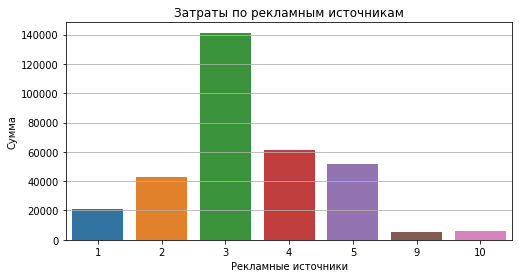

In [131]:
plt.figure(figsize=(8, 4))
ax = sns.barplot(x='source_id', y='costs', data=costs_by_source_id)
ax.set_title('Затраты по рекламным источникам')
ax.set(ylabel='Сумма')
ax.set(xlabel='Рекламные источники')
ax.grid(axis='y');

Самые крупные вложения в источник 3 (141321 ед.), затем 4 и 5, в приктически нет затрат на источники 9 и 10

In [132]:
# данные по затратам на каждый источник по дням
costs_by_data_source_id = costs_df.pivot_table(index='date', 
                                               columns='source_id', aggfunc=({'costs': 'sum'}))
costs_by_data_source_id.head()

costs                                              
source_id      1       2       3       4       5      9      10
date                                                           
2017-06-01  75.20  132.56  349.38   76.74   73.24  13.06  15.08
2017-06-02  62.25  132.38  314.22   59.21  123.82  18.13  11.18
2017-06-03  36.53   77.20  196.12   59.39   64.93   7.06   9.62
2017-06-04  55.00   79.08  389.87  161.97   52.77   4.65  17.82
2017-06-05  57.08  108.96  424.47   44.65  144.30  15.30  26.68

In [133]:
costs_by_data_source_id.describe() # описание данных

costs                                                   \
source_id          1           2            3           4           5    
count      363.000000  363.000000   363.000000  363.000000  364.000000   
mean        57.391928  117.922975   389.315785  168.246832  142.189835   
std         27.813968   53.971467   209.480437  137.033287   65.289628   
min          5.800000   15.080000    39.260000    0.830000    0.700000   
25%         36.250000   77.855000   226.480000   59.515000   92.497500   
50%         54.710000  115.970000   353.140000  130.070000  137.300000   
75%         75.630000  149.160000   504.045000  254.385000  180.350000   
max        245.750000  507.090000  1788.280000  788.030000  719.220000   

                                   
source_id          9           10  
count      363.000000  363.000000  
mean        15.199697   16.039917  
std          6.829491    9.440731  
min          1.850000    0.540000  
25%          9.795000    9.150000  
50%         14.490000   14.670000  
75%         19.975000   21.495000  
max         49.530000   68.110000

In [134]:
# данные по затратам на каждый источник по неделям
costs_by_week_source_id = costs_df.pivot_table(index='week', 
                                               columns='source_id', aggfunc=({'costs': 'sum'}))
costs_by_week_source_id.head()

costs                                                 
source_id       1       2        3        4       5      9       10
week                                                               
2017-06-01  367.04  790.61  2243.85   432.80  718.64  77.30  120.37
2017-06-08  264.55  421.99  1879.82  1109.56  629.22  61.63   60.75
2017-06-15  223.31  475.83  1681.21   834.99  582.13  66.90   68.72
2017-06-22  201.15  534.00  1480.93   895.29  533.87  58.81   49.09
2017-06-29  184.65  548.73  1666.33   670.49  547.84  62.62   62.37

In [135]:
costs_by_week_source_id.describe()

costs                                                      \
source_id          1            2            3            4            5    
count       53.000000    53.000000    53.000000    53.000000    53.000000   
mean       393.080566   807.661132  2666.445849  1152.332075   976.549057   
std        147.254740   302.989512  1050.326692   475.151828   353.642353   
min        141.700000   254.150000   822.300000   395.740000   384.630000   
25%        266.070000   547.450000  1765.100000   827.280000   670.710000   
50%        394.340000   850.750000  2669.600000  1134.850000  1026.330000   
75%        523.980000  1076.870000  3291.120000  1445.790000  1256.960000   
max        760.490000  1562.530000  6072.040000  2263.780000  1918.790000   

                                   
source_id          9           10  
count       53.000000   53.000000  
mean       104.103585  109.858302  
std         39.126889   45.056691  
min         27.370000   17.600000  
25%         77.110000   75.380000  
50%         96.190000  113.310000  
75%        130.070000  139.450000  
max        190.930000  233.470000

In [136]:
# данные по затратам на каждый источник по месяцам
costs_by_month_source_id = costs_df.pivot_table(index='month', 
                                               columns='source_id', aggfunc=({'costs': 'sum'}))
costs_by_month_source_id

costs                                                     
source_id        1        2         3        4        5       9       10
month                                                                   
2017-06-01  1125.61  2427.38   7731.65  3514.80  2616.12  285.22  314.22
2017-07-01  1072.88  2333.11   7674.37  3529.73  2998.14  302.54  329.82
2017-08-01   951.81  1811.05   6143.54  3217.36  2185.28  248.93  232.57
2017-09-01  1502.01  2985.66   9963.55  5192.26  3849.14  415.62  460.67
2017-10-01  2315.75  4845.00  15737.24  6420.84  5767.40  609.41  627.24
2017-11-01  2445.16  5247.68  17025.34  5388.82  6325.34  683.18  792.36
2017-12-01  2341.20  4897.80  16219.52  7680.47  5872.52  657.98  645.86
2018-01-01  2186.18  4157.74  14808.78  5832.79  5371.52  547.16  614.35
2018-02-01  2204.48  4474.34  14228.56  5711.96  5071.31  551.50  480.88
2018-03-01  1893.09  3943.14  13080.85  5961.87  4529.62  480.29  526.41
2018-04-01  1327.49  2993.70   9296.81  4408.49  3501.15  373.49  388.25
2018-05-01  1467.61  2689.44   9411.42  4214.21  3669.56  362.17  409.86

In [137]:
costs_by_month_source_id.describe()

costs                                                       \
source_id           1            2             3            4            5    
count        12.000000    12.000000     12.000000    12.000000    12.000000   
mean       1736.105833  3567.170000  11776.802500  5089.466667  4313.091667   
std         553.749259  1163.225836   3811.878939  1346.175985  1373.881348   
min         951.810000  1811.050000   6143.540000  3217.360000  2185.280000   
25%        1277.020000  2623.925000   8905.520000  4043.090000  3375.397500   
50%        1697.550000  3468.420000  11522.200000  5290.540000  4189.380000   
75%        2232.297500  4567.005000  15040.895000  5865.060000  5470.490000   
max        2445.160000  5247.680000  17025.340000  7680.470000  6325.340000   

                                 
source_id          9         10  
count       12.000000   12.0000  
mean       459.790833  485.2075  
std        149.734776  162.8181  
min        248.930000  232.5700  
25%        347.262500  373.6425  
50%        447.955000  470.7750  
75%        565.977500  617.5725  
max        683.180000  792.3600

**Графики распределения затрат по рекламным источникам**<a name="costs_source_graf"></a>

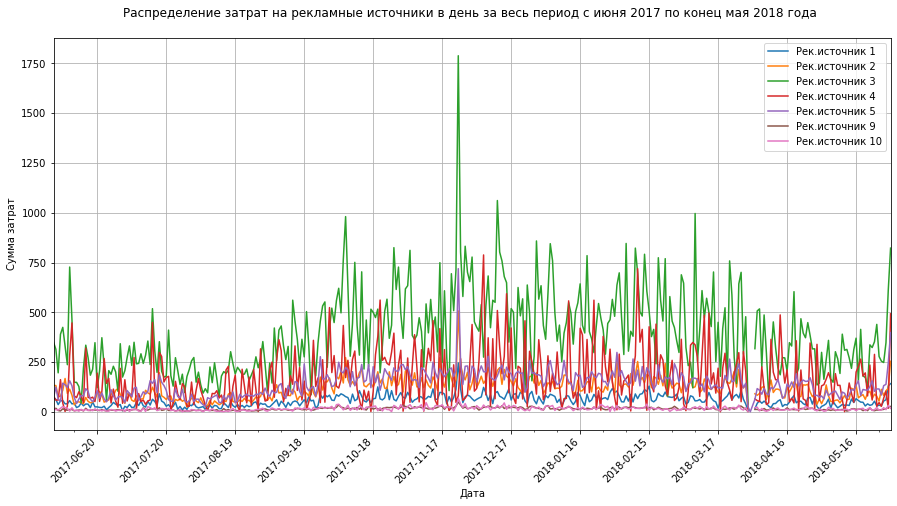

In [138]:
ax = costs_by_data_source_id.plot(figsize=(15, 8))

plt.title('Распределение затрат на рекламные источники в день за весь период с июня 2017 по конец мая 2018 года \n')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Сумма затрат')
plt.grid(axis='both')
plt.legend(['Рек.источник 1', 'Рек.источник 2', 'Рек.источник 3', 
            'Рек.источник 4', 'Рек.источник 5', 'Рек.источник 9', 'Рек.источник 10'], loc='best')

#  устанавливаем интервал основных и вспомогательных делений:
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10));

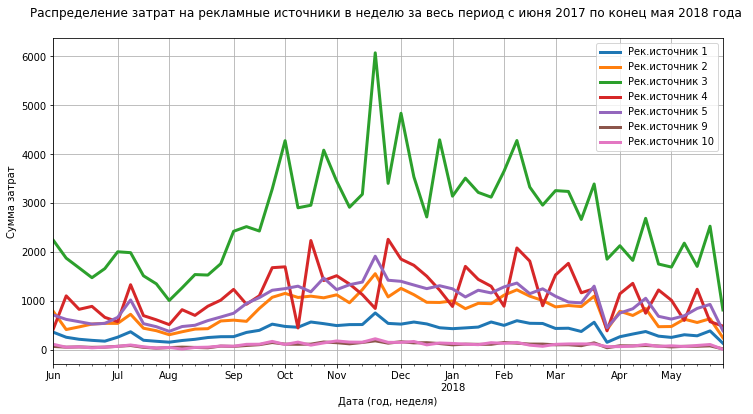

In [139]:
ax = costs_by_week_source_id.plot(figsize=(12, 6), lw=3)

plt.title('Распределение затрат на рекламные источники в неделю за весь период с июня 2017 по конец мая 2018 года \n')
plt.xlabel('Дата (год, неделя)')
plt.ylabel('Сумма затрат')
plt.grid(axis='both')
plt.legend(['Рек.источник 1', 'Рек.источник 2', 'Рек.источник 3', 
            'Рек.источник 4', 'Рек.источник 5', 'Рек.источник 9', 'Рек.источник 10'], loc='best');

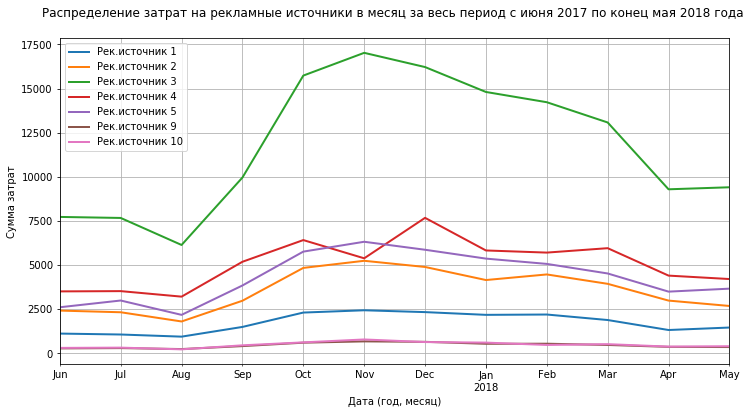

In [140]:
ax = costs_by_month_source_id.plot(figsize=(12, 6), lw=2)

plt.title('Распределение затрат на рекламные источники в месяц за весь период с июня 2017 по конец мая 2018 года \n')
plt.xlabel('Дата (год, месяц)')
plt.ylabel('Сумма затрат')
plt.grid(which='both', axis='both')
plt.legend(['Рек.источник 1', 'Рек.источник 2', 'Рек.источник 3', 
            'Рек.источник 4', 'Рек.источник 5', 'Рек.источник 9', 'Рек.источник 10'], loc='best');

- Больше всего вложений проводится в источники 3,4,5. 
- Средние показатели трат на источник №3 в два раза выше чем на следующий №4. 
- Количество переходов с источника 4 больше если рассматривать распределение переходов по неделям и месяцам.
- На №3 самые неравномерные затраты, судя по величине стандартного отклонения, резкое увеличение затрат в конце сентября, в новогодний период и в конца февраля судя по всему давало соответствующее увеличение объема продаж. 
- Соотвественно слабая поддержка каналов 9 и 10 сказывалась на количестве переходов. 
- Каналы 6,7,8 вообще не финансируются соответственно переходов с этих источников меньше всего.

**Проверим вклад рекламных источников ТОП-3 (3,4,5) в объемы продаж** <a name="costs_source_rev_graf"></a>

Посмотрим на распределение по неделям

In [141]:
costs_by_week_source_id.columns # названия столбцов по мультииндексу

MultiIndex([('costs',  1),
            ('costs',  2),
            ('costs',  3),
            ('costs',  4),
            ('costs',  5),
            ('costs',  9),
            ('costs', 10)],
           names=[None, 'source_id'])

In [142]:
source_TOP = costs_by_week_source_id[[('costs', 3), ('costs', 4), ('costs', 5)]] # затраты на источники №3-5
source_TOP.head()

costs                 
source_id         3        4       5
week                                
2017-06-01  2243.85   432.80  718.64
2017-06-08  1879.82  1109.56  629.22
2017-06-15  1681.21   834.99  582.13
2017-06-22  1480.93   895.29  533.87
2017-06-29  1666.33   670.49  547.84

**График распределение затрат на рекламные источники и выручка по неделям**

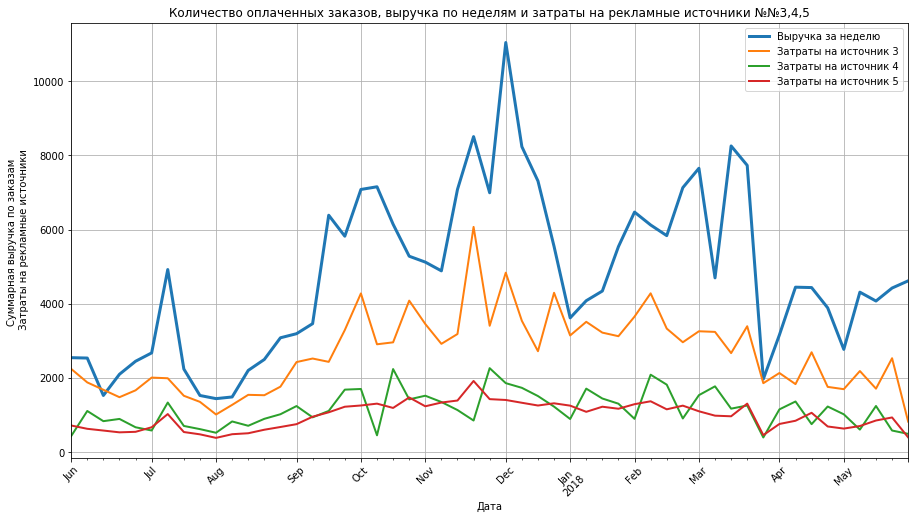

In [143]:
# данные по выручке и заказам по неделям + затраты на источники 3,4,5
ax = buy_by_week['revenue_sum'].plot(figsize=(15, 8), lw=3, xlim=('2017-05-21', '2018-06-15'))
ax1 = source_TOP.plot(figsize=(15, 8), ax=ax, lw=2)

plt.title('Количество оплаченных заказов, выручка по неделям и затраты на рекламные источники №№3,4,5')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Суммарная выручка по заказам \n Затраты на рекламные источники')
plt.grid(axis='both')
plt.legend(['Выручка за неделю', 'Затраты на источник 3', 'Затраты на источник 4', 'Затраты на источник 5'], loc='best');

**График распределение затрат на рекламные источники и выручка по дням**

Аналогично построим совмещенный график по дням

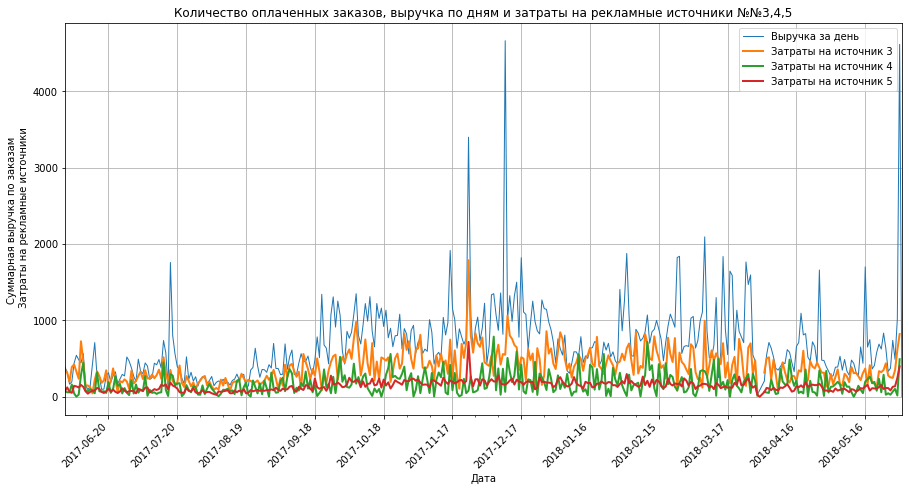

In [144]:
# данные по выручке и заказам по дням + затраты на источники 3,4,5
ax = buy_by_data['revenue_sum'].plot(figsize=(15, 8), lw=1, xlim=('2017-05-21', '2018-06-15'))
ax1 = costs_by_data_source_id[[('costs', 3), ('costs', 4), ('costs', 5)]].plot(figsize=(15, 8), ax=ax, lw=2)

plt.title('Количество оплаченных заказов, выручка по дням и затраты на рекламные источники №№3,4,5')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Суммарная выручка по заказам \n Затраты на рекламные источники')
plt.grid(axis='both')
plt.legend(['Выручка за день', 'Затраты на источник 3', 'Затраты на источник 4', 'Затраты на источник 5'], loc='best')

#  устанавливаем интервал основных и вспомогательных делений:
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10));

**Последний график нагляднее показывает совпадение рисунков затрат на три самых дорогих источника и суммарной выручки. В основном источники 3,4,5 приводят покупателей на сайт.**

### Стоимость привлечение одного покупателя из каждого источника<a name="costs_source_uid"></a>

In [145]:
visits_df.head() # данные по визитам

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_data,first_activ_data,first_activ_month,first_activ_week,cohort_lifetime,session_duration_minute
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,2017-12-14,2017-12-20,2017-12-20,2017-12-01,2017-12-14,0,18.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,2018-02-15,2018-02-19,2018-02-19,2018-02-01,2018-02-15,0,28.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,2017-06-29,2017-07-01,2017-07-01,2017-07-01,2017-06-29,0,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,2018-05-17,2018-05-20,2018-03-09,2018-03-01,2018-03-08,2,24.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,2017-12-21,2017-12-27,2017-12-27,2017-12-01,2017-12-21,0,0.0


In [146]:
# данные первого перехода привязанные к рекламному источнику перехода
first_source = visits_df.groupby(['uid', 'source_id']).agg({'first_activ_data': 'min'}).reset_index()
first_source.head()

,uid,source_id,first_activ_data
0,11863502262781,3,2018-03-01
1,49537067089222,2,2018-02-06
2,297729379853735,3,2017-06-07
3,313578113262317,2,2017-09-18
4,325320750514679,5,2017-09-30


In [147]:
first_source.shape

(277870, 3)

In [148]:
# выделим первый день покупки
first_orders_data = orders_df.groupby('uid').agg({'data': 'min'}).reset_index()
first_orders_data.columns = ['uid', 'first_activ_data']
first_orders_data.head()

,uid,first_activ_data
0,313578113262317,2018-01-03
1,1575281904278712,2017-06-03
2,2429014661409475,2017-10-11
3,2464366381792757,2018-01-28
4,2551852515556206,2017-11-24


In [149]:
first_orders_data.shape

(36523, 2)

In [150]:
# совместим информацию по дате первой покупки и первого перехода с источника
orders_source = pd.merge(first_source, first_orders_data, on=['uid', 'first_activ_data'])
orders_source.head()

,uid,source_id,first_activ_data
0,1575281904278712,10,2017-06-03
1,2429014661409475,3,2017-10-11
2,2551852515556206,5,2017-11-24
3,3077748354309989,3,2018-03-03
4,3753586865891862,4,2018-03-03


In [151]:
orders_source.shape

(33533, 3)

In [152]:
# cформируем когорты покупателей по источникам
orders_source['month'] = orders_source['first_activ_data'].astype('datetime64[M]')
cohorts_source = orders_source.groupby(['month', 'source_id']).agg({'uid':'nunique'}).reset_index()
cohorts_source.head()

,month,source_id,uid
0,2017-06-01,1,283
1,2017-06-01,2,331
2,2017-06-01,3,723
3,2017-06-01,4,518
4,2017-06-01,5,485


In [153]:
cohorts_source.shape

(85, 3)

In [154]:
# когорты затрат по источникам
costs_source_id = costs_df.groupby(['month', 'source_id']).agg({'costs':'sum'}).reset_index()
costs_source_id.head()

,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


In [155]:
costs_source_id.shape

(84, 3)

In [156]:
# данные по месячным затратам на источники рассчитанные ранее
costs_by_month_source_id.head(1) 

costs                                                   
source_id        1        2        3       4        5       9       10
month                                                                 
2017-06-01  1125.61  2427.38  7731.65  3514.8  2616.12  285.22  314.22

In [157]:
# обозначим столбцы по номерам источников
costs_by_month_source_id.columns = ['1','2', '3', '4', '5', '9', '10']
costs_by_month_source_id

,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


In [158]:
# данные по когортам пользователей по источникам 
cohorts_source_uid = cohorts_source.pivot_table(index='month', columns='source_id', aggfunc=({'uid': 'sum'}))
# обозначим столбцы по номерам источников
cohorts_source_uid.columns = ['1','2', '3', '4', '5', '7', '9', '10']
cohorts_source_uid

,1,2,3,4,5,7,9,10
month,,,,,,,,
2017-06-01,283.0,331.0,723.0,518.0,485.0,NaN,137.0,92.0
2017-07-01,252.0,252.0,500.0,499.0,440.0,NaN,107.0,50.0
2017-08-01,170.0,159.0,341.0,351.0,352.0,1.0,92.0,40.0
2017-09-01,303.0,292.0,678.0,562.0,611.0,NaN,129.0,78.0
2017-10-01,483.0,499.0,1055.0,1083.0,938.0,NaN,199.0,193.0
2017-11-01,456.0,467.0,985.0,1027.0,637.0,NaN,194.0,101.0
2017-12-01,445.0,399.0,974.0,1074.0,665.0,NaN,166.0,61.0
2018-01-01,289.0,259.0,732.0,779.0,558.0,NaN,95.0,76.0
2018-02-01,322.0,286.0,798.0,788.0,561.0,NaN,82.0,106.0


Удалим рекламный источник 7 из данных по выручке, потому что по ним нет затрат на продвижение, пользуются ими единицы пользователей, выручка от них несущественная.

In [159]:
cohorts_source_uid.drop(['7'], axis='columns', inplace=True)

**Итоговая таблица - "Количество пользователей (в месяц) по первому переходу с рекламного источника".**

In [160]:
cohorts_source_uid 

,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,283.0,331.0,723.0,518.0,485.0,137.0,92.0
2017-07-01,252.0,252.0,500.0,499.0,440.0,107.0,50.0
2017-08-01,170.0,159.0,341.0,351.0,352.0,92.0,40.0
2017-09-01,303.0,292.0,678.0,562.0,611.0,129.0,78.0
2017-10-01,483.0,499.0,1055.0,1083.0,938.0,199.0,193.0
2017-11-01,456.0,467.0,985.0,1027.0,637.0,194.0,101.0
2017-12-01,445.0,399.0,974.0,1074.0,665.0,166.0,61.0
2018-01-01,289.0,259.0,732.0,779.0,558.0,95.0,76.0
2018-02-01,322.0,286.0,798.0,788.0,561.0,82.0,106.0


Поделим две базы (одинаковые по размерам 7х12). 

$$Затраты \ на \ каждого \ покупателя \ по \ рекламным \ источникам \ = \frac{Данные \ по \ затратам \ на \ рекламные \ источники}{Данные \ по \ количеству \ покупателей \ с \ каждого \ источника}$$

In [161]:
result_source_per_uid = costs_by_month_source_id / cohorts_source_uid
result_source_per_uid # данные по затратам на каждого пользователя

,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,3.977420,7.333474,10.693845,6.785328,5.394062,2.081898,3.415435
2017-07-01,4.257460,9.258373,15.348740,7.073607,6.813955,2.827477,6.596400
2017-08-01,5.598882,11.390252,18.016246,9.166268,6.208182,2.705761,5.814250
2017-09-01,4.957129,10.224863,14.695501,9.238897,6.299738,3.221860,5.906026
2017-10-01,4.794513,9.709419,14.916815,5.928753,6.148614,3.062362,3.249948
2017-11-01,5.362193,11.237002,17.284609,5.247147,9.929890,3.521546,7.845149
2017-12-01,5.261124,12.275188,16.652485,7.151276,8.830857,3.963735,10.587869
2018-01-01,7.564637,16.053050,20.230574,7.487535,9.626380,5.759579,8.083553
2018-02-01,6.846211,15.644545,17.830276,7.248680,9.039768,6.725610,4.536604


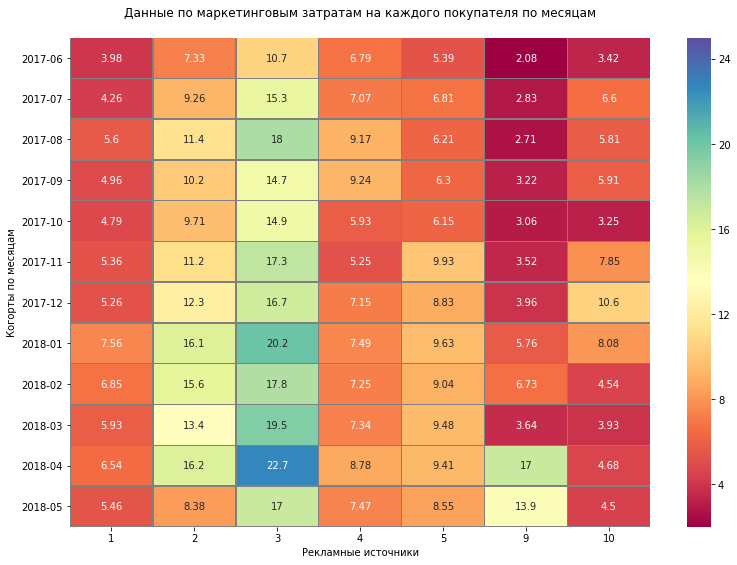

In [162]:
plt.figure(figsize=(13, 9))
sns.heatmap(result_source_per_uid, annot=True, vmin=2, vmax=25, fmt='.3g',
            linewidths=0.5, linecolor='gray', cmap='Spectral', yticklabels=y_name);
plt.title('Данные по маркетинговым затратам на каждого покупателя по месяцам\n')
plt.xlabel('Рекламные источники')
plt.ylabel('Когорты по месяцам');

In [163]:
# вспомним общие затраты на рекламные источники за период
costs_by_source_id = costs_df.groupby('source_id').agg({'costs': 'sum'}).reset_index()
costs_by_source_id

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


- Самые дорогие в привлечении пользователей это источники 2-5.   
- Источник 3 хотя бы приводит пользователей и увеличивает продажи, а вот №2 плохо с этим справляется.  
- Источник 4 оптимальнее всех работает - приток заказов в совокупности за год лучше всех из рекламных источников.  
- Аутсайдеры 9 и 10 похоже только зря сжигают деньги компании.

## Насколько окупились расходы? (ROI)<a name="roi"></a>

In [164]:
report_ltv.head() # данные по LTV рассчитанные ранее 

,first_month,uid_count,month,revenue,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531


Затраты на каждого покупателя по источникам рассчитанные до этого - по сути **САС по каждому источнику** (затраты разделенные на количество покупателей привлеченных с этого источника)

In [165]:
result_source_per_uid

,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,3.977420,7.333474,10.693845,6.785328,5.394062,2.081898,3.415435
2017-07-01,4.257460,9.258373,15.348740,7.073607,6.813955,2.827477,6.596400
2017-08-01,5.598882,11.390252,18.016246,9.166268,6.208182,2.705761,5.814250
2017-09-01,4.957129,10.224863,14.695501,9.238897,6.299738,3.221860,5.906026
2017-10-01,4.794513,9.709419,14.916815,5.928753,6.148614,3.062362,3.249948
2017-11-01,5.362193,11.237002,17.284609,5.247147,9.929890,3.521546,7.845149
2017-12-01,5.261124,12.275188,16.652485,7.151276,8.830857,3.963735,10.587869
2018-01-01,7.564637,16.053050,20.230574,7.487535,9.626380,5.759579,8.083553
2018-02-01,6.846211,15.644545,17.830276,7.248680,9.039768,6.725610,4.536604


Средние затраты на одного покупателя рассчитаем из суммы затрат по всем источникам / на количество источников   
в результате получим средний **САС на каждого покупателя.**

In [166]:
# просуммируем по столбцам таблицу и разделим на кол-во столбцов - получим средний САС
result_source_per_uid['cac'] = result_source_per_uid.select_dtypes(float).sum(1)/7
result_source_per_uid

,1,2,3,4,5,9,10,cac
month,,,,,,,,
2017-06-01,3.977420,7.333474,10.693845,6.785328,5.394062,2.081898,3.415435,5.668780
2017-07-01,4.257460,9.258373,15.348740,7.073607,6.813955,2.827477,6.596400,7.453716
2017-08-01,5.598882,11.390252,18.016246,9.166268,6.208182,2.705761,5.814250,8.414263
2017-09-01,4.957129,10.224863,14.695501,9.238897,6.299738,3.221860,5.906026,7.792002
2017-10-01,4.794513,9.709419,14.916815,5.928753,6.148614,3.062362,3.249948,6.830061
2017-11-01,5.362193,11.237002,17.284609,5.247147,9.929890,3.521546,7.845149,8.632505
2017-12-01,5.261124,12.275188,16.652485,7.151276,8.830857,3.963735,10.587869,9.246076
2018-01-01,7.564637,16.053050,20.230574,7.487535,9.626380,5.759579,8.083553,10.686472
2018-02-01,6.846211,15.644545,17.830276,7.248680,9.039768,6.725610,4.536604,9.695956


In [167]:
# выделим данные по САС в отдельную таблицу
cac = result_source_per_uid[['cac']]
cac

,cac
month,
2017-06-01,5.668780
2017-07-01,7.453716
2017-08-01,8.414263
2017-09-01,7.792002
2017-10-01,6.830061
2017-11-01,8.632505
2017-12-01,9.246076
2018-01-01,10.686472
2018-02-01,9.695956


In [168]:
# объединим таблицу с расчетом LTV и таблицу с САС по месяцу
report_romi = pd.merge(report_ltv, cac, left_on='first_month', right_on='month')
report_romi

,first_month,uid_count,month,revenue,age,ltv,cac
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,5.668780
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329,5.668780
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637,5.668780
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671,5.668780
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531,5.668780
...,...,...,...,...,...,...,...
73,2018-03-01,3533,2018-04-01,1063.05,1,0.300892,9.028205
74,2018-03-01,3533,2018-05-01,1114.87,2,0.315559,9.028205
75,2018-04-01,2276,2018-04-01,10600.69,0,4.657597,12.177820
76,2018-04-01,2276,2018-05-01,1209.92,1,0.531599,12.177820


In [169]:
# посчитаем ROMI
report_romi['romi'] = report_romi['ltv'] / report_romi['cac']
report_romi.head()

,first_month,uid_count,month,revenue,age,ltv,cac,romi
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,5.66878,0.833409
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329,5.66878,0.085614
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637,5.66878,0.077201
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671,5.66878,0.168409
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531,5.66878,0.180379


In [170]:
result_romi = report_romi.pivot_table(
                          index='first_month', 
                          columns='age', 
                          values='romi', 
                          aggfunc='mean')
# показатель ROMI имеет накопительный характер поэтому применяем кумулятивную сумму
result_romi.cumsum(axis=1).round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_month,,,,,,,,,,,,
2017-06-01,0.83,0.92,1,1.16,1.35,1.47,1.64,1.75,1.84,1.95,2.05,2.1
2017-07-01,0.81,0.85,0.93,0.98,1.01,1.03,1.04,1.06,1.08,1.1,1.13,
2017-08-01,0.63,0.68,0.74,0.78,0.84,0.88,0.9,0.95,0.98,1.01,,
2017-09-01,0.72,0.87,0.93,1.44,1.5,1.58,1.67,1.7,1.72,,,
2017-10-01,0.73,0.81,0.84,0.86,0.88,0.9,0.91,0.93,,,,
2017-11-01,0.60,0.64,0.67,0.7,0.72,0.73,0.74,,,,,
2017-12-01,0.51,0.54,0.64,0.76,0.79,0.83,,,,,,
2018-01-01,0.39,0.41,0.44,0.46,0.46,,,,,,,
2018-02-01,0.43,0.46,0.47,0.47,,,,,,,,


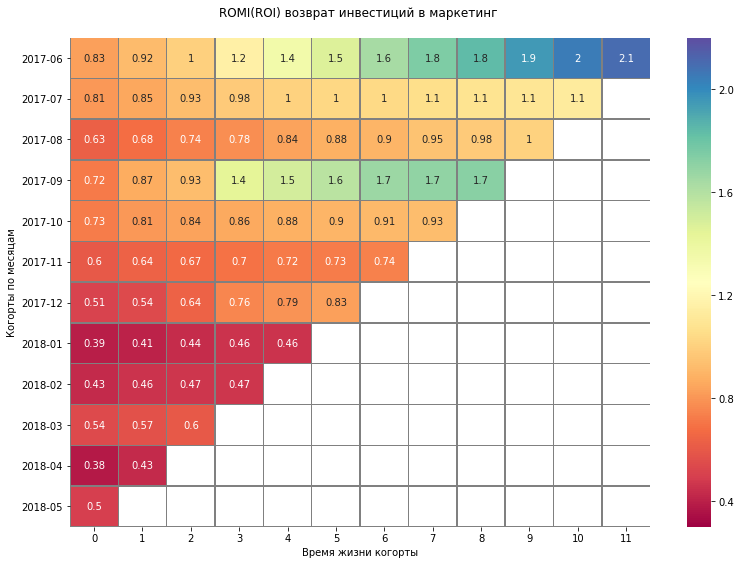

In [171]:
plt.figure(figsize=(13, 9))
sns.heatmap(result_romi.cumsum(axis=1).round(2), annot=True, vmin=0.3, vmax=2.2, fmt='.2g',
            linewidths=0.5, linecolor='gray', cmap='Spectral', yticklabels=y_name)
plt.title('ROMI(ROI) возврат инвестиций в маркетинг \n')
plt.xlabel('Время жизни когорты')
plt.ylabel('Когорты по месяцам');

In [172]:
result_romi.cumsum(axis=1).mean(axis=0) # средний срок окупаемости когорт

age
0     0.588964
1     0.653073
2     0.726260
3     0.847616
4     0.943579
5     1.059171
6     1.152085
7     1.277908
8     1.408973
9     1.353535
10    1.587717
11    2.095554
dtype: float64

- Средний срок окупаемости когорт - 5-6 месяцев. 
- По настоящему вложения окупаются после 8-9 мес. существования
- За первые 6 месяцев окупились три когорты - июнь, июль и сентябрь, причем для июня и сентября раньше - за 4 мес.
- Судя по динамике остальным когортам понадобится не меньше 11-12 месяцев для достижение окупаемости.

**Проверим накопительный LTV за 6 месяцев после первой покупки**

In [173]:
m6_cum_ltv = result_ltv.cumsum(axis=1).mean(axis=0)[5]
print('Средний LTV за 6 месяцев после первой покупки:{: .2f}'.format(m6_cum_ltv))
print()
m6_cum_cac = result_ltv.cumsum(axis=0).mean(axis=1)[5]
print('Средние затраты на одного пользователя (CAC) \nза 6 месяцев после первой покупки: {: >16.2f}'.format(m6_cum_cac))

Средний LTV за 6 месяцев после первой покупки: 7.97

Средние затраты на одного пользователя (CAC) 
за 6 месяцев после первой покупки:             7.19


**Чтобы затраты на маркетинг окупались в ближайшие 6 месяцев нужно чтобы средние затраты на пользователя не превышали 7,19 ед.** 

### Итоги по блоку "Маркетинг" <a name="result_marketing"></a>

#### Общие  затраты 
Сумма общих затрат за период = 329 131.62   

#### Затраты по рекламным источникам
- Самые крупные вложения компания делает в источник 3, затем 4 и 5, и практически нет затрат на источники 9 и 10.  
- Слабая поддержка каналов 9 и 10 сказывается на количестве переходов - их мало по сравнению с остальными.    
- Каналы 6,7,8 вообще не финансируются соответственно переходов с этих источников меньше всего.
- Средние показатели трат на источник 3 в два раза выше чем на следующий 4.    
- Количество переходов с источника 4 больше, если рассматривать распределение переходов по неделям и месяцам.

На источник 3 самые неравномерные траты, судя по величине стандартного отклонения, резкое увеличение затрат в конце сентября,   
в новогодний период и в конца февраля, судя по всему давало соответствующее увеличение объема продаж.

По рассмотренным распределениям затрат на источники по дням и неделям есть совпадение по рисункам графиков затрат на три самых дорогих источника и суммарной выручки. **В основном источники 3,4,5 приводят покупателей на сайт.**

#### Стоимость привлечение одного покупателя из каждого источника
Для получения информации разделили одну таблицу на другую

$$Затраты \ на \ каждого \ пользователя \ по \ рекламным \ источникам \ = \frac{Данные \ по \ затратам \ на \ рекламные \ источники}{Данные \ по \ количеству \ пользователей \ с \ каждого \ источника}$$

- Самые дорогие в привлечении пользователей это источники 2-5.   
- Источник 3 приводит пользователей и увеличивает продажи, а вот №2 плохо с этим справляется.  
- Источник 4 оптимальнее всех работает - приток заказов в совокупности за год лучше всех из рекламных источников.  
- На источники 9 и 10 зря траться средства - приток пользователей с них самый низкий.


### Насколько окупились расходы? (ROMI(ROI))

- Средний срок окупаемости когорт - 5-6 месяцев. 
- По настоящему вложения окупаются после 8-9 мес. существования
- За первые 6 месяцев окупились три когорты - июнь, июль и сентябрь, причем для июня и сентября раньше - за 4 мес.
- Судя по динамике остальным когортам понадобится не меньше 11-12 месяцев для достижение окупаемости.
    
Средний LTV за 6 месяцев после первой покупки: 7.97    
Средние затраты на одного пользователя (CAC) 
за 6 месяцев после первой покупки:             7.19 

**Затраты на маркетинг могут окупаться за расчетные 6 месяцев, если средние затраты на пользователя не превысят 7,19 ед.** 

### [Заключение](#end)

#### Обзор данных
**Были предоставлены данные с июня 2017 по конец мая 2018 в трех категориях:**
- база визитов на сайт - список всех сессий пользователей
- база покупок на сайте 
- данные по затратам на маркетинг - оплата рекламных источников.

**Состав данных:**
- всего 359 400 сессий, из них уникальных пользователей 228 тыс. - порядка 60%; 
- оплаченных заказов на сайте около 50 тыс., из них уникальных пользователей 36 523 - 72%;
----------
- в системе фиксируются два устройства входа - "настольное" и "мобильное";
- количество переходов с настольных устройств более чем в 2 раза больше (262 тыс. vs 96 тыс.);
----------
- рекламных источников всего 10;
- наибольший приток пользователей с источников с 1 по 5;
- переходов с источников 6, 7 практически нет, источник 8 не используется клиентами.
----------
**Конверсия пользователей в покупателей = 16% (хороший результат по рынку)**

#### Анализ по категории "Продукт"

**Пользователи сервиса в день, неделю, месяц**

- **DAU** (daily active users) — количество уникальных пользователей в день = **907**.
- **WAU** (weekly active users) — количество уникальных пользователей в неделю = **5621**.
- **MAU** (monthly active users) — количество уникальных пользователей в месяц = **23228**

Количество пользователей росло с августа по декабрь 2017, и снижалось далее до мая 2018 но не ниже уровня начала наблюдений.
Сервис постоянно прирастает новыми пользователями.
Прирост пользователей обеспечивают рекламные источники:
- больше всего переходов с источников 3,4,5;
- меньше всего переходов с источников 9 и 10
- источники 6 и 7 практически бесполезны.

#### Повторные обращения пользователей 
Повторно к сервису обращается 16 человек из 100 в неделю и всего 4 из 100 каждый месяц.    
**Retention Rate** - коэффициент удержания пользователя очень низкий. В первый месяц существования когорты падает **до 5-10%** и с каждым новым месяцем снижается еще больше, в каких-то случаях до **2-4% или до нуля**. Первая когорта самая лояльная - больше всего коэф. удержания в среднем.

#### Количество сессий в день 
Практически каждый пользователь заходит на сайт не более одного раза в день.    
Рост количества сессий с августа 2017 до новогоднего периода покупок отразился на количестве продаж и выручке. Заметно что в конце сентября, ноябре-декабре 2017 стали покупать не сильно чаще но больше - объем выручки вырос сильнее чем объем заказов.

#### Длительность одной сессии
**общая самая типичная сессия по продолжительности 1 минута**.
Средняя сессия длилась около 10 мин., при этом медиана всего 5 минут. 
В общем плане сессии с мобильных устройств обычно короче чем на настольных.   

Длительности сессий по рекламным источникам:
- Самые короткие в среднем с источников 3, 4, 5, при этом их больше всего. 
- Самые длинные - с источников  1, 2.

#### Продажи

#### Продолжительность сессии первой покупки
Типичное время покупки составляет 1 минута. 
Клиент быстро находит, что нужно и совершают покупки.   
Возможно состав предложения на сайте ограничен и нет причин задерживаться дольше.
    
**Количество покупок  за период**
    
- В среднем каждый покупатель совершает покупки 1 раз в день/неделю/месяц.
- Средний покупатель за полгода делает покупки 7 раз (чуть больше 1 раза в месяц).
- В день, в среднем, совершают покупки 127 пользователей.
- В неделю, в среднем, совершают покупки 818 пользователей.
- В месяц, в среднем, совершают покупки 3155 пользователей. 

#### Средний чек
- Средний чек по всем периодам колеблется в "среднем" около 4,8-5 ед. 
- Средний чек заметно выше в новогодний период. Падение в январе. Всплески в середине июня и сентябре 2017, в конце февраля 2018 (перед 8 марта).
**Когортный анализ среднего чека**
- Средний чек уникального покупателя для всех когорт растет (за редким исключением)
- Коэффициент удержания по когортам снижается с каждым месяцем, средний чек расчитанный помесячно в пределах 5 ед., получается что лояльные пользователи когорты тратят больше в каждом последующем месяце.

**Активность покупателей в когорте**
- Самые активные пользователи 3-4 раза в месяц в среднем, другие лояльные пользователи совершают в среднем 1,5-2 покупки.

**Лояльные покупают больше и чаще**

#### Выручка и доход с каждого пользователя (LTV)
Согласно расчетам деятельность компании, по известным нам данным, убыточна = - 77 тыс.*** 

**Расчет LTV по выручке**
- Накопительная ценность клиента у первых шести когорт стабильно растет, хотя и низкими темпами до 7-12 ед.
- За первые 6 месяцев существования 4 из семи когорт показали рост LTV выше 7 ед.

#### Общие  затраты 
>Сумма общих затрат за период = 329 131.62   

#### Затраты по рекламным источникам
- Самые крупные вложения компания делает в источник 3, затем 4 и 5, и практически нет затрат на источники 9 и 10.  
- Слабая поддержка каналов 9 и 10 сказывается на количестве переходов - их мало по сравнению с остальными.    
- Каналы 6,7,8 вообще не финансируются соответственно переходов с этих источников меньше всего.
---
- Средние показатели трат на источник 3 в два раза выше чем на следующий 4.    
- Количество переходов с источника 4 больше, если рассматривать распределение переходов по неделям и месяцам.
- На источник 3 самые неравномерные траты, резкое увеличение затрат в конце сентября,   в новогодний период и в конца февраля, давало соответствующее увеличение объема продаж.
---
**Основном приток покупателей на сайт от источников 3,4,5**

#### Стоимость привлечение одного покупателя из каждого источника
- Самые дорогие в привлечении пользователей это источники 2-5.   
- Источник 3 приводит пользователей и увеличивает продажи, от источника №2 приток покупателей гораздо ниже.  
- Источник 4 оптимальнее всех работает - приток заказов в совокупности за год лучше всех из рекламных источников.  
- На источники 9 и 10 зря траться средства - приток пользователей с них самый низкий.


### Насколько окупились расходы? (ROMI(ROI))
- Средний срок окупаемости когорт - 5-6 месяцев. 
- По настоящему вложения окупаются после 8-9 мес. существования
- За первые 6 месяцев окупились три когорты - июнь, июль и сентябрь, причем для июня и сентября раньше - за 4 мес.
- Судя по динамике остальным когортам понадобится не меньше 11-12 месяцев для достижение окупаемости.
    
Средний LTV за 6 месяцев после первой покупки: 7.97    
Средние затраты на одного пользователя (CAC) 
за 6 месяцев после первой покупки:             7.19  

**Затраты на маркетинг могут окупаться за расчетные 6 месяцев, если средние затраты на пользователя не превысят 7,19 ед.**  

### Выводы и рекомендации
**Оптимизация расходов**
- Пересмотреть вложения в рекламные источники
    - снизить затраты на источники 1 и 2 
    - за счет этого увеличить расходы на источники 3-5
    - из иточников 3-5 затраты распределить равномерно между ними - тогда выстрелит по продажам источник 4
    - по источникам 9-10 прекратить финансирование
    - провести пробную акцию финансирования источников 6-8 с целью выявления потенциала на привлечения
- Контролировать уровень расходов, основываясь на цеелвых показателям ROMI за 6 месяцев.

**Оптимизация выручки**
- главной задачей сделать удержание клиента и повторные продажи;
- увеличивать приток новых пользователей через проверенные источники рекламы;
- расширить ассортимент услуг;
- оценить возможность увеличения притока мобильных пользователей;
- самими стать рекламным источником - получить дополнительный канал поступления выручки (пользователи пока явно не справляются).